# Unfolding Matrix

We attempt to unfold the generator jet multiplicity distribution
through unfolding the measured distribution 

We take genjets data from MC
and require the following:

* |eta| < 5.0
* pt > 30
* no gen-leptons from Ws w/n deltaR 0.4 
* pt<sub>lep</sub> > 10GeV

PUPPI reco jet container is used.

<b>Method:</b>
 
* Measure the puppi reco/data jet multiplicity after random forest selection and $|\eta| < 2.4$
* Scale the measured multiplicity to the preselection value
* Unfold for pileup distribution
* Unfold for detector effects



<b>Things todo:</b>

* Uncertainties

In [1]:
import os, sys, copy, pickle
sys.path.append(os.getcwd() + "/../")
from prep_ana_II import *
matplotlib.rcParams.update({'font.size': 26})


Welcome to JupyROOT 6.10/00
home /home/gunter/WW_analysis/production/Analysis_13TeV
Loading binning options...
Loading plotting options
unc_mc_process and scales are parameter dictionaries


In [2]:
%matplotlib inline

## Set-up

In [3]:
def load_ww(file_path="../data/gen_jets/WW_WW_34.root"):
    df_ww = rp.read_root("../data/gen_jets/WW_WW_34.root")
    df = pre_cuts(df_ww)

    return df

In [4]:
#loading data
df_ww = rp.read_root("../data/gen_jets/WW_WW_34.root")

rfs = load_randomForest()
fDY = rfs["clf_fDY"]
fTT = rfs["clf_fTT"]
features_fDY = rfs["features_fDY"]
features_fTT = rfs["features_fTT"]

In [5]:
#Creating DeltaR 
df_ww["dPhi_gj_rj"] = df_ww.genjet1_phi - df_ww.jet1_phi
df_ww["dEta_gj_rj"] = df_ww.genjet1_eta - df_ww.jet1_eta
df_ww.dEta_gj_rj.values[df_ww.dEta_gj_rj.values > np.pi] -= 2*np.pi
df_ww.dEta_gj_rj.values[df_ww.dEta_gj_rj.values <= -np.pi] += 2*np.pi

df_ww["dR_gj_rj"] = (df_ww.dPhi_gj_rj.values**2. + df_ww.dEta_gj_rj**2.)**0.5

#Creating DeltaR for PUPPI
df_ww["dPhi_gj_puj"] = df_ww.genjet1_phi - df_ww.pujet1_phi
df_ww["dEta_gj_puj"] = df_ww.genjet1_eta - df_ww.pujet1_eta
df_ww.dEta_gj_puj.values[df_ww.dEta_gj_puj.values > np.pi] -= 2*np.pi
df_ww.dEta_gj_puj.values[df_ww.dEta_gj_puj.values <= -np.pi] += 2*np.pi

df_ww["dR_gj_puj"] = (df_ww.dPhi_gj_puj.values**2. + df_ww.dEta_gj_puj**2.)**0.5

#Making Delta Pt
df_ww["dPT"] = df_ww.jet1_pt - df_ww.genjet1_pt

In [6]:
#Applying preselection cuts
df = pre_cuts(df_ww)

pred_fTT = fTT.predict_proba(np.float32(df[features_fTT].values))
df["pred_fTT_WW"] = pred_fTT[:,0]
pred_fDY = fDY.predict_proba(np.float32(df[features_fDY].values))
df["pred_fDY_WW"] = pred_fDY[:,0]

In [62]:
#Apply WWpt sf and uncertainties
def apply_wwpt_corr(df):
    import ROOT
    f = ROOT.TFile.Open("/home/gunter/WW_analysis/production/Analysis_13TeV/tools/WW_pTresummation_13-master/MyRatioWWpTHistogramAll.root", "read")

    wwpt_hist = f.Get("wwpt")
    wwpt_rup_hist = f.Get("wwpt_resumup")
    wwpt_rdown_hist = f.Get("wwpt_resumdown")
    wwpt_sup_hist = f.Get("wwpt_scaleup")
    wwpt_sdown_hist = f.Get("wwpt_scaledown")

    df["wwpt_weight"] = np.ones(df.shape[0])
    df["wwpt_weight_rup"] = np.ones(df.shape[0])
    df["wwpt_weight_rdown"] = np.ones(df.shape[0])
    df["wwpt_weight_sup"] = np.ones(df.shape[0])
    df["wwpt_weight_sdown"] = np.ones(df.shape[0])

    for i in range(1000):
        weight =  wwpt_hist.GetBinContent(i)
        rup =  wwpt_rup_hist.GetBinContent(i)
        rdown =  wwpt_rdown_hist.GetBinContent(i)
        sup =  wwpt_sup_hist.GetBinContent(i)
        sdown =  wwpt_sdown_hist.GetBinContent(i)

        df.weight.values[(df.ww_pt >= i*0.5 ).values & (df.ww_pt < i*0.5 + 0.5).values] *= weight
        df.wwpt_weight.values[(df.ww_pt >= i*0.5 ).values & (df.ww_pt < i*0.5 + 0.5).values] *= weight

        df.wwpt_weight_rup.values[(df.ww_pt >= i*0.5 ).values & (df.ww_pt < i*0.5 + 0.5).values]   *= weight * rup
        df.wwpt_weight_rdown.values[(df.ww_pt >= i*0.5 ).values & (df.ww_pt < i*0.5 + 0.5).values] *= weight * rdown
        df.wwpt_weight_sup.values[(df.ww_pt >= i*0.5 ).values & (df.ww_pt < i*0.5 + 0.5).values]   *= weight * sup
        df.wwpt_weight_sdown.values[(df.ww_pt >= i*0.5 ).values & (df.ww_pt < i*0.5 + 0.5).values] *= weight * sdown
apply_wwpt_corr(df)
apply_wwpt_corr(df_ww)

In [8]:
def jet_bin_conv(arr):
    l = np.zeros(3)
    for it in range(arr.shape[0]):
        if it < 2:
            l[it] += arr[it] 
        else:
            l[2] += arr[it]
    return l

In [9]:
def count_WWs(df, scales=scales):
    n = 0 
    for process in df[df.process == "WW"].process_decay.unique():
        n += df[df.process_decay == process].weight.sum() * scales[process]
    return n

## $\mathrm{RF}_{0.9, 0.6}$ to Presel scale factor

In [10]:
a = np.histogram(df.numb_jets.values, 
                 weights=df.weight.values,
                 range=(-0.5, 9.5), bins=10)
b = np.histogram(df.query("pred_fDY_WW > 0.9 & pred_fTT_WW > 0.6").numb_puppi_jets.values, 
                 weights=df.query("pred_fDY_WW > 0.9 & pred_fTT_WW > 0.6").weight.values,
                 range=(-0.5, 9.5), bins=10)

sf = jet_bin_conv(a[0]) / jet_bin_conv(b[0])
print "scale factors", sf

scale factors [  1.72817303   7.08379748  54.05677338]


## Method


* Measure the reco/data jet multiplicity after random forest selection
* Scale the measured multiplicity to the preselection value
* Unfold to matched distribution (Corrects for pile-up)
* Unfold that distribution using matched reco, gen jet matching matrix

Issues:

How do you evaluate uncertainties?


In [11]:
#Matched scale factor
matched_vec = np.array([count_WWs(df.query("numb_matched_jets == 0 ")),\
           count_WWs(df.query("numb_matched_jets == 1 ")),\
           count_WWs(df.query("numb_matched_jets >= 2 "))], dtype=float)
reco_vec = np.array([count_WWs(df.query("numb_jets == 0")),\
           count_WWs(df.query("numb_jets == 1")),\
           count_WWs(df.query("numb_jets >= 2"))], dtype=float)

matched_sf = matched_vec/reco_vec
print "matched", matched_sf


matched [ 1.04423997  0.96285481  0.90224816]


In [79]:
#Weighted matrices
def stat_countWWs(df):
    stat = 0
    for process in df[df.process == "WW"].process_decay.unique():
        w = df[df.process_decay == process].weight.values
        stat += np.sqrt((w**2.).sum()) / w.sum() * scales[process] * w.shape[0]
    return stat

def construct_matrix(df, jet_type="puppi_24_", count_WWs=count_WWs):
    no_match_numerator = []; no_match_demoninator = []
    reco_matrix = []; matched_matrix = []
    detector_matrix = []
    pileup_matrix = []
    nums = []; doms_gen = []; doms_reco = []
    stat_pu_matrix = []; stat_det_matrix = []
    nums_det = []; nums_pu = [];

    for i in range(3):

        no_match_numerator.append([]); no_match_demoninator.append([])
        reco_matrix.append([]); matched_matrix.append([])
        detector_matrix.append([])
        pileup_matrix.append([])
        nums.append([]); nums_det.append([]); nums_pu.append([])
        stat_pu_matrix.append([]); stat_det_matrix.append([])
        
        for j in range(3):
            i_numb_jets = "numb_" + jet_type + "jets == "; j_numb_jets = copy.copy(i_numb_jets)
            alt= jet_type
            if jet_type == "puppi_24_":
                alt = "_24"
            
            i_numb_matched_jets = "numb_matched_"+jet_type+"jets == "; j_numb_matched_jets = copy.copy(i_numb_matched_jets)
            if jet_type == "puppi_":
                alt = ""
            i_numb_gen_jets = "numb_gen_jets"+alt+" == "; j_numb_gen_jets = copy.copy(i_numb_gen_jets)

            if i == 2:
                i_numb_jets = i_numb_jets[:-3] + ">= "
                i_numb_matched_jets = i_numb_matched_jets[:-3] + ">= "
            if j == 2:
                j_numb_jets = j_numb_jets[:-3] + ">= "
                j_numb_gen_jets = j_numb_gen_jets[:-3] + ">= "
                j_numb_matched_jets = j_numb_matched_jets[:-3] + ">= "

            no_match_demoninator[i].append(count_WWs(df.query(i_numb_jets +\
                                           str(i) + " & " + j_numb_gen_jets + str(j))))
            no_match_numerator[i].append(count_WWs(df.query(i_numb_jets + str(i) +\
                                           " & " + j_numb_gen_jets + str(j) +\
                                           "& numb_matched_"+jet_type+"jets < " + str(i))))

            reco_matrix[i].append(count_WWs(df.query(i_numb_jets +str(i) +\
                                " & " + j_numb_gen_jets + str(j))) /\
                                  count_WWs(df.query(i_numb_jets + str(i))) )

            
            pileup_matrix[i].append(count_WWs(df.query(j_numb_matched_jets + str(j) +\
                                        " & " + i_numb_jets + str(i))) /\
                                     count_WWs(df.query(j_numb_matched_jets + str(j))) )
            detector_matrix[i].append(count_WWs(df.query(j_numb_gen_jets + str(j) +\
                                        " & " + i_numb_matched_jets + str(i) )) /\
                                     count_WWs(df.query(j_numb_gen_jets + str(j))))
            
            nums[i].append(count_WWs(df.query(j_numb_gen_jets + str(j) +\
                                        " & " + i_numb_jets + str(i))))
            
            nums_det[i].append(count_WWs(df.query(j_numb_gen_jets + str(j) +\
                                        " & " + i_numb_matched_jets + str(i))))
            
            nums_pu[i].append(count_WWs(df.query(j_numb_matched_jets + str(j) +\
                                        " & " + i_numb_jets + str(i))))
            
            sigma_a = stat_countWWs(df.query(j_numb_matched_jets + str(j) + " & " + i_numb_jets + str(i)))
            sigma_b = stat_countWWs(df.query(j_numb_matched_jets + str(j)))
            a = count_WWs(df.query(j_numb_matched_jets + str(j) + " & " + i_numb_jets + str(i)))
            b = count_WWs(df.query(j_numb_matched_jets + str(j)))
            stat_pu_matrix[i].append(((sigma_a/b)**2. + (a*sigma_b/b**2.)**2.)**.5)
            
            sigma_a = stat_countWWs(df.query(j_numb_gen_jets + str(j) +" & " + i_numb_matched_jets + str(i) ))
            sigma_b = stat_countWWs(df.query(j_numb_gen_jets + str(j)))
            a = count_WWs(df.query(j_numb_gen_jets + str(j) + " & " + i_numb_matched_jets + str(i)))
            b = count_WWs(df.query(j_numb_gen_jets + str(j)))
            stat_det_matrix[i].append(((sigma_a/b)**2. + (a*sigma_b/b**2.)**2.)**.5)
            if i == 0:
                doms_gen.append(count_WWs(df.query(j_numb_gen_jets + str(j))))
                doms_reco.append(count_WWs(df.query(j_numb_jets + str(j))))
            

    no_match_numerator = np.array(no_match_numerator); no_match_demoninator = np.array(no_match_demoninator)
    nonmatched_matrix = no_match_numerator / no_match_demoninator
    reco_matrix = np.array(reco_matrix)
    pileup_matrix = np.array(pileup_matrix)
    detector_matrix = np.array(detector_matrix)
    nums = np.array(nums)
    doms_gen = np.array(doms_gen)
    doms_reco = np.array(doms_reco)
    
    tot_matrix = np.ones((3,3))
    tot_matrix[:3,0] = tot_matrix[:3,0] * doms_gen[0]
    tot_matrix[:3,1] = tot_matrix[:3,1] * doms_gen[1]
    tot_matrix[:3,2] = tot_matrix[:3,2] * doms_gen[2]
    tot_matrix = nums/tot_matrix
    
    return {"reco_matrix": reco_matrix,
            "pileup_matrix": pileup_matrix,
            "detector_matrix": detector_matrix,
            "nonmatched_matrix": nonmatched_matrix,
            "nums": nums, "nums_det": nums_det, "nums_pu": nums_pu,
            "doms_gen": doms_gen,
            "doms_reco": doms_reco,
            "stat_det": stat_det_matrix,
            "stat_pu": stat_pu_matrix,
            "tot_matrix": tot_matrix}
a   = construct_matrix(df)
print "Non matched: \n", a["nonmatched_matrix"]
print "Pileup: \n", a["pileup_matrix"]
print "Detector: \n", a["detector_matrix"]
print "Reco Matched reco: \n", a["reco_matrix"]
print "Tot: ", a["tot_matrix"]
a   = construct_matrix(df, "")
pickle.dump(a, open("../data/Unfolding/june13.pkl", "w"))

Non matched: 
[[ 0.          0.          0.        ]
 [ 0.02086788  0.0030085   0.00165831]
 [ 0.09355883  0.02060273  0.0042076 ]]
Pileup: 
[[  9.97954808e-01   1.25106944e-01   1.08842882e-02]
 [  1.99995663e-03   8.72617941e-01   1.68753931e-01]
 [  4.53734455e-05   2.27517335e-03   8.20361756e-01]]
Detector: 
[[ 0.91840509  0.11726347  0.01284577]
 [ 0.07766893  0.79101343  0.16991351]
 [ 0.0039261   0.09172312  0.81724079]]
Reco Matched reco: 
[[ 0.93272056  0.06366339  0.00361597]
 [ 0.08968877  0.81436786  0.09594335]
 [ 0.00558849  0.11065735  0.88375408]]
Tot:  [[  9.60155840e-01   1.49878879e-01   1.93888850e-02]
 [  3.89170215e-02   8.08132657e-01   2.16847626e-01]
 [  9.27222276e-04   4.19884640e-02   7.63763514e-01]]


In [277]:
#closer test
a = construct_matrix(df)
pileup_matrix = a["pileup_matrix"]; inv_pileup_matrix = np.linalg.inv(pileup_matrix)
detector_matrix = a["detector_matrix"]; inv_detector_matrix = np.linalg.inv(detector_matrix)

reco_vec = np.array([count_WWs(df.query("numb_puppi_24_jets == 0 ")),\
           count_WWs(df.query("numb_puppi_24_jets == 1 ")),\
           count_WWs(df.query("numb_puppi_24_jets >= 2 "))], dtype=float)
gen_vec = np.array([count_WWs(df.query("numb_gen_jets_24 == 0")),\
           count_WWs(df.query("numb_gen_jets_24 == 1")),\
           count_WWs(df.query("numb_gen_jets_24 >= 2"))], dtype=float)
print "gen", gen_vec
print "estimate matched", np.dot(inv_pileup_matrix, reco_vec)
print "estimate gen", np.dot(np.dot(reco_vec, inv_pileup_matrix.T), inv_detector_matrix.T)
print "reco", reco_vec
print "estimate reco", np.dot(reco_matched_matrix, np.dot(matched_matrix, gen_vec))

gen [ 22719.51717532   9519.97218464   4134.82352497]
estimate matched [ 22082.0115493    9957.6070308    4334.69152306]
estimate gen [ 22719.51506803   9519.9719007    4134.82430811]
reco [ 23354.04086433   9446.41103003   3573.85971382]
estimate reco [ 22334.35180147  11774.39124571   5851.48494262]


In [268]:
a = construct_matrix(df, "")
pileup_matrix = a["pileup_matrix"]; inv_pileup_matrix = np.linalg.inv(pileup_matrix)
detector_matrix = a["detector_matrix"]; inv_detector_matrix = np.linalg.inv(detector_matrix)

reco_vec = np.array([count_WWs(df.query("numb_jets == 0 ")),\
           count_WWs(df.query("numb_jets == 1 ")),\
           count_WWs(df.query("numb_jets >= 2 "))], dtype=float)
gen_vec = np.array([count_WWs(df.query("numb_gen_jets == 0")),\
           count_WWs(df.query("numb_gen_jets == 1")),\
           count_WWs(df.query("numb_gen_jets >= 2"))], dtype=float)
print "gen", gen_vec
print "estimate matched", np.dot(inv_pileup_matrix, reco_vec)
print "estimate gen", np.dot(np.dot(reco_vec, inv_pileup_matrix), inv_detector_matrix)
print "reco", reco_vec
print "estimate reco", np.dot(reco_matched_matrix, np.dot(matched_matrix, gen_vec))

gen [ 22196.50982705   9536.05496277   4641.74852069]
estimate matched [ 21612.83818864   9799.37086425   4962.10071996]
estimate gen [ 21830.06756089  10016.17029237   4987.96002814]
reco [ 20697.19485806  10177.41181097   5499.70749265]
estimate reco [ 21827.27985675  11709.03921593   6225.56451054]


In [137]:
#closer test by sampling distributions
estimated_gen_vec = []
for i in range(1000):
    test_sample = df[["numb_jets", "numb_matched_jets", "numb_gen_jets", "weight", "process", "process_decay"]].sample(frac=0.25, replace=True)
    reco_vec = np.array([count_WWs(test_sample.query("numb_jets == 0 ")),\
               count_WWs(test_sample.query("numb_jets == 1 ")),\
               count_WWs(test_sample.query("numb_jets >= 2 "))], dtype=float)
    estimated_gen_vec.append( np.dot(np.dot(4*reco_vec, reco_matched_matrix), matched_matrix) )
estimated_gen_vec = np.array(estimated_gen_vec)

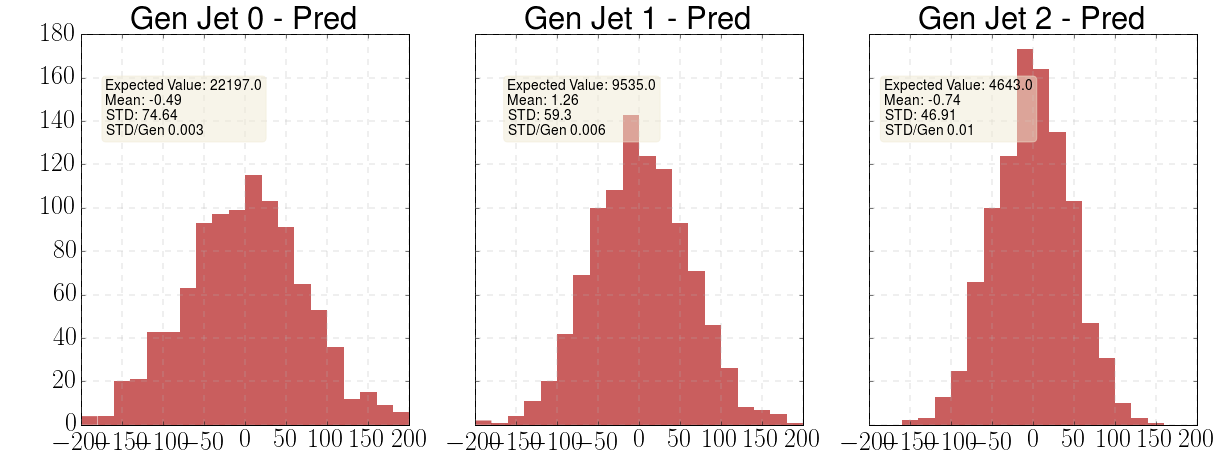

In [182]:
# Distributions for the different jet bins
fig, ax = plt.subplots(1, 3, figsize=(20,7), sharey=True )

diff_gen_0 = (gen_vec - np.array(estimated_gen_vec))[:,0]
diff_gen_1 = (gen_vec - np.array(estimated_gen_vec))[:,1]
diff_gen_2 = (gen_vec - np.array(estimated_gen_vec))[:,2]

purp_c  = [0.5, 0, .99]
gold_c  = [0.99, 0.5, 0]
mor_c = [.7, .1, .1, .7]
ax[0].grid(color=(0.7,0.7,0.7), alpha=0.2, linestyle='--', linewidth=2)
ax[1].grid(color=(0.7,0.7,0.7), alpha=0.2, linestyle='--', linewidth=2)
ax[2].grid(color=(0.7,0.7,0.7), alpha=0.2, linestyle='--', linewidth=2)

ax[0].hist(diff_gen_0, color=mor_c, range=(-200,200), bins=20, edgecolor="none")
ax[1].hist(diff_gen_1, color=mor_c, range=(-200,200), bins=20, edgecolor="none")
ax[2].hist(diff_gen_2, color=mor_c, range=(-200,200), bins=20, edgecolor="none")

ax[0].set_title("Gen Jet 0 - Pred")
ax[1].set_title("Gen Jet 1 - Pred")
ax[2].set_title("Gen Jet 2 - Pred")

text_0 = "Expected Value: " + str(round(np.array(estimated_gen_vec)[:,0].mean(),0)) +\
"\nMean: " + str(round(diff_gen_0.mean(), 2)) +\
"\nSTD: " + str(round(diff_gen_0.std(), 2)) +\
"\nSTD/Gen " + str(round(diff_gen_0.std() / gen_vec[0], 3))
ax[0].text(0.05, 1.2, text_0 , fontsize=14, transform=c.transAxes,
        verticalalignment='top', bbox=props, )

text_1 = "Expected Value: " + str( round(np.array(estimated_gen_vec)[:,1].mean(),0) ) +\
"\nMean: " + str(round(diff_gen_1.mean(), 2)) +\
"\nSTD: " + str(round(diff_gen_1.std(), 2)) +\
"\nSTD/Gen " + str(round(diff_gen_1.std() / gen_vec[1], 3))
ax[1].text(0.85, 1.2, text_1 , fontsize=14, transform=c.transAxes,
        verticalalignment='top', bbox=props, )

text_2 = "Expected Value: " + str( round(np.array(estimated_gen_vec)[:,2].mean(),0) ) +\
"\nMean: " + str(round(diff_gen_2.mean(), 2)) +\
"\nSTD: " + str(round(diff_gen_2.std(), 2)) +\
"\nSTD/Gen " + str(round(diff_gen_2.std() / gen_vec[2], 3))
ax[2].text(1.6, 1.2, text_2 , fontsize=14, transform=c.transAxes,
        verticalalignment='top', bbox=props, )


### Covariance Matrix

In [99]:
#Covariences and Correlations
estimate = np.array([11690, 1733, 91]) * sf
a = construct_matrix(df, "")
R_inv = np.round(np.linalg.inv(np.dot(a["pileup_matrix"], a["detector_matrix"])),2)

covar = np.dot(np.dot(R_inv, np.diag(estimate)), R_inv.T)
delta = np.diagonal(np.dot(np.dot(R_inv, np.diag(estimate)), R_inv.T))**.5
temp_ = np.ones(shape=(3,3))* delta * (np.ones(shape=(3,3)) * delta).T
print "response matrix\n", np.round(R_inv, 2)
print "Covar\n", np.round(covar, 2)
print "Delta\n", np.round(delta, 2)
print "coefficient\n", np.round( covar / temp_, 2)

response matrix
[[ 1.11 -0.08  0.  ]
 [-0.12  1.24 -0.12]
 [ 0.   -0.15  1.11]]
Covar
[[ 24969.87  -3908.75    147.31]
 [ -3908.75  19237.67  -2938.61]
 [   147.31  -2938.61   6337.12]]
Delta
[ 158.02  138.7    79.61]
coefficient
[[ 1.   -0.18  0.01]
 [-0.18  1.   -0.27]
 [ 0.01 -0.27  1.  ]]


### Calc Unc

Done:
* Pileup sf
* WWpt sf
* Statistical
* !Lepton sf!
* !Jet scale!

Todo:
* Jet res
* PDF
* QCD

#### Pileup

Change scale factors using pileup scale factor variants.

In [46]:
def puCountWWs(df, up_down="up"):
    variant = "pileup_up_weight"
    if up_down == "down":
        variant = "pileup_down_weight"
    elif up_down != "up":
        print "this function accepts only up and down"
        return 0
    n = 0
    for process in df[df.process == "WW"].process_decay.unique():
        w = df[df.process_decay == process].weight.values
        w = (w / df[df.process_decay == process].pileup_weight ) * df[df.process_decay == process][variant].values
        n += w.sum() * scales[process]
    return n
def puCountWWs_Down(df):
    return puCountWWs(df, up_down="down")

In [71]:
# Pileup Effect on the Resonce Matrix Result
a = None
nominal = construct_matrix(df, "")
temp_up = construct_matrix(df, "", count_WWs=puCountWWs)
temp_down = construct_matrix(df, "", count_WWs=puCountWWs_Down)

diffs_up   = nominal["pileup_matrix"] - temp_up["pileup_matrix"]
diffs_down = nominal["pileup_matrix"] - temp_down["pileup_matrix"]
diffs = (np.abs(diffs_up) + np.abs(diffs_down)) / 2.
diff_percent = diffs / nominal["pileup_matrix"]
print "PU Diffs(%)\n", np.round(diff_percent, 4)
print "PU diffs\n", np.round(diffs, 4)

diffs_up   = nominal["detector_matrix"] - temp_up["detector_matrix"]
diffs_down = nominal["detector_matrix"] - temp_down["detector_matrix"]
diffs = (np.abs(diffs_up) + np.abs(diffs_down)) / 2.
diff_percent = diffs / nominal["detector_matrix"]
print "Det Diffs(%)\n", np.round(diff_percent, 4)
print "Det diffs\n", np.round(diffs, 4)

diffs_up   = nominal["tot_matrix"] - temp_up["tot_matrix"]
diffs_down = nominal["tot_matrix"] - temp_down["tot_matrix"]
diffs = (np.abs(diffs_up) + np.abs(diffs_down)) / 2.
diff_percent = diffs / nominal["tot_matrix"]

pileup_matrix_unc = diffs
print "Tot Diffs(%)\n", np.round(diff_percent, 4)
print "Tot diffs\n", np.round(diffs, 4)


PU Diffs(%)
[[ 0.0026     nan     nan]
 [ 0.0569  0.0025     nan]
 [ 0.0683  0.0547  0.    ]]
PU diffs
[[ 0.0025  0.      0.    ]
 [ 0.0021  0.0024  0.    ]
 [ 0.0003  0.0024  0.    ]]
Det Diffs(%)
[[ 0.001   0.0047  0.0063]
 [ 0.0159  0.0016  0.0051]
 [ 0.0354  0.0147  0.0005]]
Det diffs
[[ 0.0009  0.0003  0.    ]
 [ 0.0009  0.0014  0.0005]
 [ 0.0001  0.0011  0.0005]]
Tot Diffs(%)
[[ 0.0036  0.0032  0.0035]
 [ 0.031   0.0039  0.0021]
 [ 0.0602  0.0273  0.0002]]
Tot diffs
[[ 0.0032  0.0002  0.    ]
 [ 0.0027  0.0032  0.0002]
 [ 0.0006  0.003   0.0002]]


/home/gunter/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in divide
  # Remove the CWD from sys.path while we load stuff.


#### WWpt

In [52]:
def wwptCountWWs(df, rsup_rsdown="sup"):
    variants = {"sup":"wwpt_weight_sup", "rup": "wwpt_weight_rup",\
                "sdown":"wwpt_weight_sdown", "rdown":"wwpt_weight_rdown",
                "nominal": "wwpt_weight"}
    variant = variants["nominal"]
    if rsup_rsdown in variants:
        variant = variants[rsup_rsdown]
    n = 0
    for process in df[df.process == "WW"].process_decay.unique():
        w = df[df.process_decay == process].weight.values
        w = (w / df[df.process_decay == process].wwpt_weight ) * df[df.process_decay == process][variant].values
        n += w.sum() * scales[process]
    return n

def wwptCountWWs_SDown(df):
    return wwptCountWWs(df, rsup_rsdown="sdown")

def wwptCountWWs_RUp(df):
    return wwptCountWWs(df, rsup_rsdown="rup")

def wwptCountWWs_RDown(df):
    return wwptCountWWs(df, rsup_rsdown="rdown")

In [55]:
# WWpt uncertainty result
a = construct_matrix(df, "")
reco_matrix = a["pileup_matrix"]
diffs_sup = reco_matrix - construct_matrix(df, "", count_WWs=wwptCountWWs)["pileup_matrix"]
diffs_sdown = reco_matrix - construct_matrix(df, "", count_WWs=wwptCountWWs_SDown)["pileup_matrix"]
diffs_rup = reco_matrix - construct_matrix(df, "", count_WWs=wwptCountWWs_RUp)["pileup_matrix"]
diffs_rdown = reco_matrix - construct_matrix(df, "", count_WWs=wwptCountWWs_RDown)["pileup_matrix"]

diffs_s = (np.abs(diffs_sup) + np.abs(diffs_sdown)) / 2.
diffs_r = (np.abs(diffs_rup) + np.abs(diffs_rdown)) / 2.

diff_percent_s = diffs_s / reco_matrix
diff_percent_r = diffs_r / reco_matrix

#print "PU Diffs S (%)\n", np.round(diff_percent_s, 4)
#print "PU Diffs S  \n", np.round(diffs_s, 4)

#print "PU Diffs R (%)\n", np.round(diff_percent_r, 4)
#print "PU Diffs\n", np.round(diffs_r,4)

print "tot\n", np.round((diffs_s**2 + diffs_r**2)**.5, 4)

tot
[[ 0.0002  0.      0.    ]
 [ 0.0001  0.0002  0.    ]
 [ 0.      0.0002  0.    ]]


/home/gunter/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in divide
  if sys.path[0] == '':
/home/gunter/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in divide
  del sys.path[0]


In [56]:
reco_matrix = a["detector_matrix"]
diffs_sup   = reco_matrix - construct_matrix(df, "", count_WWs=wwptCountWWs)["detector_matrix"]
diffs_sdown = reco_matrix - construct_matrix(df, "", count_WWs=wwptCountWWs_SDown)["detector_matrix"]
diffs_rup   = reco_matrix - construct_matrix(df, "", count_WWs=wwptCountWWs_RUp)["detector_matrix"]
diffs_rdown = reco_matrix - construct_matrix(df, "", count_WWs=wwptCountWWs_RDown)["detector_matrix"]

diffs_s = (np.abs(diffs_sup) + np.abs(diffs_sdown)) / 2.
diffs_r = (np.abs(diffs_rup) + np.abs(diffs_rdown)) / 2.

diff_percent_s = diffs_s / reco_matrix
diff_percent_r = diffs_r / reco_matrix

#print "det Diffs S (%)\n", np.round(diff_percent_s, 4)
#print "det Diffs\n", np.round(diffs_s, 4)

#print "det Diffs R (%)\n", np.round(diff_percent_r, 4)
#print "det Diffs\n", np.round(diffs_r, 4)

print "tot\n", np.round((diffs_s**2 + diffs_r**2)**.5, 4)

tot
[[ 0.0059  0.0055  0.0004]
 [ 0.0057  0.0042  0.0026]
 [ 0.0002  0.0013  0.003 ]]


In [59]:
reco_matrix = a["tot_matrix"]
diffs_sup   = reco_matrix - construct_matrix(df, "", count_WWs=wwptCountWWs)["tot_matrix"]
diffs_sdown = reco_matrix - construct_matrix(df, "", count_WWs=wwptCountWWs_SDown)["tot_matrix"]
diffs_rup   = reco_matrix - construct_matrix(df, "", count_WWs=wwptCountWWs_RUp)["tot_matrix"]
diffs_rdown = reco_matrix - construct_matrix(df, "", count_WWs=wwptCountWWs_RDown)["tot_matrix"]

diffs_s = (np.abs(diffs_sup) + np.abs(diffs_sdown)) / 2.
diffs_r = (np.abs(diffs_rup) + np.abs(diffs_rdown)) / 2.

diff_percent_s = diffs_s / reco_matrix
diff_percent_r = diffs_r / reco_matrix

#print "det Diffs S (%)\n", np.round(diff_percent_s, 4)
#print "det Diffs\n", np.round(diffs_s, 4)

#print "det Diffs R (%)\n", np.round(diff_percent_r, 4)
#print "det Diffs\n", np.round(diffs_r, 4)

wwpt_matrix_unc =  (diffs_s**2 + diffs_r**2)**.5
print "tot\n", np.round(wwpt_matrix_unc, 4)

tot
[[ 0.0055  0.0053  0.0004]
 [ 0.005   0.0038  0.0025]
 [ 0.0004  0.0016  0.0029]]


#### Lepton Scale Factors

In [49]:
def lep_unc(df, up_down="up"):
    """
    lepton scale should scale the weights of samples with atleast one muon by the uncertainty on that muons scale factor
    So: w -> w * (1 +/- unc)
    """
    weights = np.ones(df.shape[0])
    weights *= df.weight.values

    if up_down == "up":
        pm = 1
        error_string1 = "lep1_id_error_high"
        error_string2 = "lep2_id_error_high"
    else:
        pm = -1
        error_string1 = "lep1_id_error_low"
        error_string2 = "lep2_id_error_low"

    weights =  weights * (1 + pm * df[error_string1].values)
    weights =  weights * (1 + pm * df[error_string2].values)

    return weights

def lepCountWWs(df, up_down="up"):
    n = 0
    for process in df[df.process == "WW"].process_decay.unique():
        w = lep_unc(df[df.process_decay == process], up_down="up")
        n += w.sum() * scales[process]
    return n

def lepCountWWs_Down(df, up_down="down"):
    n = 0
    for process in df[df.process == "WW"].process_decay.unique():
        w = lep_unc(df[df.process_decay == process], up_down="down")
        n += w.sum() * scales[process]
    return n

In [60]:
#Lepton scale !looks weird!
a = None
nominal = construct_matrix(df, "")
temp_up = construct_matrix(df, "", count_WWs=lepCountWWs)
temp_down = construct_matrix(df, "", count_WWs=lepCountWWs_Down)

diffs_up   = nominal["pileup_matrix"] - temp_up["pileup_matrix"]
diffs_down = nominal["pileup_matrix"] - temp_down["pileup_matrix"]
diffs = (np.abs(diffs_up) + np.abs(diffs_down)) / 2.
diff_percent = diffs / nominal["pileup_matrix"]
print "PU Diffs(%)\n", np.round(diff_percent, 5)
print "PU Diffs\n", np.round(diffs, 5)

diffs_up   = nominal["detector_matrix"] - temp_up["detector_matrix"]
diffs_down = nominal["detector_matrix"] - temp_down["detector_matrix"]
diffs = (np.abs(diffs_up) + np.abs(diffs_down)) / 2.
diff_percent = diffs / nominal["detector_matrix"]
print "Det Diffs(%)\n", np.round(diff_percent, 5)
print "Det Diffs\n", np.round(diffs, 5)

diffs_up   = nominal["tot_matrix"] - temp_up["tot_matrix"]
diffs_down = nominal["tot_matrix"] - temp_down["tot_matrix"]
diffs = (np.abs(diffs_up) + np.abs(diffs_down)) / 2.
diff_percent = diffs / nominal["tot_matrix"]
lep_matrix_unc = diffs
print "Tot Diffs(%)\n", np.round(diff_percent, 5)
print "Tot Diffs\n", np.round(diffs, 5)

PU Diffs(%)
[[  2.00000000e-05              nan              nan]
 [  3.10000000e-04   3.00000000e-05              nan]
 [  7.20000000e-04   7.40000000e-04   0.00000000e+00]]
PU Diffs
[[  2.00000000e-05   0.00000000e+00   0.00000000e+00]
 [  1.00000000e-05   3.00000000e-05   0.00000000e+00]
 [  0.00000000e+00   3.00000000e-05   0.00000000e+00]]
Det Diffs(%)
[[  3.00000000e-05   6.70000000e-04   4.90000000e-04]
 [  5.50000000e-04   1.00000000e-05   1.17000000e-03]
 [  6.00000000e-05   4.10000000e-04   1.20000000e-04]]
Det Diffs
[[  3.00000000e-05   4.00000000e-05   0.00000000e+00]
 [  3.00000000e-05   1.00000000e-05   1.10000000e-04]
 [  0.00000000e+00   3.00000000e-05   1.10000000e-04]]
Tot Diffs(%)
[[  1.00000000e-05   7.00000000e-04   9.50000000e-04]
 [  1.50000000e-04   5.00000000e-05   1.06000000e-03]
 [  7.00000000e-05   1.00000000e-05   1.00000000e-04]]
Tot Diffs
[[  1.00000000e-05   4.00000000e-05   0.00000000e+00]
 [  1.00000000e-05   4.00000000e-05   9.00000000e-05]
 [  0.0000

/home/gunter/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in divide
  # Remove the CWD from sys.path while we load stuff.


#### Jet scale

In [13]:
sys.path.append("tools/")
sys.path.append(os.getcwd() + "/../../tools/fit/")
sys.path.append("/home/gunter/WW_analysis/production/Analysis_13TeV/tools/jecsys/")
from JECUncertainty import JECUncertainty, jecUncertainties


In [32]:
def loadJECUnc():
    JECUnc = pickle.load(open("/home/gunter/WW_analysis/production/Analysis_13TeV/scripts/uncertainties_dir/data/jecDump.pkl", "r"))
    return JECUnc
    
def apply_binned_jet_uncertainty( df, bins, pt_bins, eta_bins):
  #Apply binned uncertainty to WW and see how jet bin hist change
  #bins, pt_bins, eta_bins

  for k in df.keys():
    if "jet" in k[:3] and "eta" in k:
      if "gen" in k:
        continue
      else:
        df[ k[:-3]+"unc"] = 0.

  pt_ = 30
  for it, pt in enumerate(pt_bins):
    #print "pt:", pt_, pt_ + pt
    eta_ = -5
    for jt, eta in enumerate(eta_bins):
      #print "eta:", eta_, eta_ + eta
      for k in df.keys():
        if "gen" in k:
          continue
        if "jet" in k[:3] and "eta" in k:
          if pt_ == 30:
            selection = (df[k[:-3] + "pt"] >= 20.) &\
                        (df[k[:-3] +"pt"] < pt_ + pt) &\
                        (df[k] >= eta_) &\
                        (df[k] < eta_ + eta)
          else:
            selection = (df[k[:-3] + "pt"] >= pt_) &\
                        (df[k[:-3] +"pt"] < pt_ + pt) &\
                        (df[k] >= eta_) &\
                        (df[k] < eta_ + eta)
          df[k[:-3]+"unc"].values[selection] = bins[it][jt]

      eta_ += eta
    pt_ += pt

    
    
def jet_scale_shift_official(data, pt_cut=30, up_down="up", rf=rfs):
  #?Is this working as advertized
  vec_ht_values_sin_orig = copy.copy(data.HT.values) * 0
  vec_ht_values_cos_orig = copy.copy(data.HT.values) * 0

  vec_ht_values_sin_post = copy.copy(data.HT.values) * 0
  vec_ht_values_cos_post = copy.copy(data.HT.values) * 0


  if "jet1_unc" not in data.keys():
    print data.keys()
    print "\033[1mJet1 unc is not available...\033[0m"
  ht_values = copy.copy(data.HT.values)
  data.HT = data.HT * 0
  #Scale pt of each jet
  if up_down == "up":
    thingoo = 1
  else:
    thingoo = -1
  for k in data.keys():
    if "bjet" in k: continue
    if "jet" in k[:3] and "unc" in k: 
      if "gen" in k: continue
      #Original vec_ht values Energy scale  
      vec_ht_values_sin_orig += data[k[:4] + "_pt"] * np.sin(data[k[:4] + "_phi"]) 
      vec_ht_values_cos_orig += data[k[:4] + "_pt"] * np.cos(data[k[:4] + "_phi"])
      
  
      data[k[:-3]+"pt"] = data[k[:-3]+"pt"] * np.abs(thingoo + data[k])
  #######?Same loop maybe
  for k in data.keys():
    if "bjet" in k: continue
    if "jet" in k[:3] and "pt" in k:
      if "gen" in k: continue
      ht_lost_jet = data[k] >= pt_cut
      data.HT.values[ht_lost_jet] = data[ht_lost_jet].HT.values + data[ht_lost_jet][k].values 

      #Post uncertainty corrected  vec_ht values 
      vec_ht_values_sin_post += data[k] * np.sin(data[k[:4] + "_phi"])
      vec_ht_values_cos_post += data[k] * np.cos(data[k[:4] + "_phi"])
      #print "SIN STUFF", k,  np.sin(data[data[k[:4] + "_pt"] > 0][k[:4] + "_phi"].values[:5])

  #MET results
  #?met projected isn't right need to change
  previous_met = copy.copy(data.metMod.values )
  data.metMod  = np.sqrt( (data.metMod * np.sin(data.met_phi) - vec_ht_values_sin_orig + vec_ht_values_sin_post )**2 +\
                          (data.metMod * np.cos(data.met_phi) - vec_ht_values_cos_orig + vec_ht_values_cos_post )**2 )
  data.METProj = data.metMod.values / previous_met * data.METProj # np.abs(data.METProj - (ht_values - data.HT))
  data.recoil  = np.sqrt( (data.metMod * np.sin(data.met_phi) + data.lep1_pt * np.sin(data.lep1_phi) + data.lep2_pt * np.sin(data.lep2_phi))**2 +\
                          (data.metMod * np.cos(data.met_phi) + data.lep1_pt * np.cos(data.lep1_phi) + data.lep2_pt * np.cos(data.lep2_phi))**2 )
  #Update number of jets
  kill_jets( data, pt_cut )

  #Add dPhiXJet stuff 
  data.dPhiMETJet.values[data.numb_jets.values == 0] = -1
  data.dPhiLLJet.values[data.numb_jets.values == 0] = -1

  if rf != None:
  #print "Recreating random forest scores."
    pred_fTT = rf["clf_fTT"].predict_proba(np.float32(data[rf["features_fTT"]].values))
    data["fTT"] = pred_fTT[:,0]

    temp = data[rf["features_fDY"]]
    temp = temp.replace([np.inf,-np.inf], 0)
    pred_fDY = rf["clf_fDY"].predict_proba(np.float32(temp.values))
    data["fDY"] = pred_fDY[:,0]

def kill_jets(df, pt_cut=30):
  """
  Edit number of jets in event based on pt cut
  """
  #?Not quite what I should be doing..
  n_jets = np.zeros(df.shape[0]) #np.maximum(np.zeros(df.shape[0]), df.numb_jets.values - 6)
  for k in df.keys():
    if "bjet" in k: continue
    if "jet" in k[:3] and "pt" in k:
      if "gen" in k: continue
      cut = (df[k] > pt_cut)
      n_jets[cut.values] = n_jets[cut.values] + 1

  df["numb_jets"] = n_jets

JECUnc = loadJECUnc()

In [63]:
#jet scale
reco_matrix = construct_matrix(df, "")["nums"]

apply_binned_jet_uncertainty(df, JECUnc["bins"], JECUnc["pt_bins"], JECUnc["eta_bins"])
jet_scale_shift_official(df, rf=rfs, up_down="up")
diffs_up = reco_matrix - construct_matrix(df, "")["nums"]

df = pre_cuts(df_ww)
apply_binned_jet_uncertainty(df, JECUnc["bins"], JECUnc["pt_bins"], JECUnc["eta_bins"])
jet_scale_shift_official(df, rf=rfs, up_down="down")

diffs_down = reco_matrix - construct_matrix(df, "")["nums"]
diffs = (np.abs(diffs_up) + np.abs(diffs_down)) / 2.
diff_percent = diffs / reco_matrix

df = pre_cuts(df_ww)
a = np.ones((3,3))
results = construct_matrix(df, "")
a[:3,0] = a[:3,0] * results["doms_gen"][0]
a[:3,1] = a[:3,1] * results["doms_gen"][1]
a[:3,2] = a[:3,2] * results["doms_gen"][2]
jetSR_matrix_unc = diffs / a
print "Diffs(%)\n", diff_percent * 100.
print "Diffs\n", np.round(diffs / a,4)
#print "mean(%)", diff_percent[diff_percent > 0].mean() * 100.

Diffs(%)
[[  4.43900302  21.15463152  30.15113024]
 [ 14.99112609   1.29545388  18.70905845]
 [ 24.13186835  17.99807668   2.09832054]]
Diffs
[[ 0.0382  0.0124  0.0009]
 [ 0.0124  0.0107  0.016 ]
 [ 0.0022  0.02    0.0192]]


#### Statistical uncertainties

In [66]:
#You should be using this stat_count but you won't
def calc_stat(dics):
    r = []
    for i, row in enumerate(dics["nums"]):
        r.append([])
        for j, ij in enumerate(row):
            r[i].append( ((ij**.5 / dics["doms_gen"][j])**2. + (ij * dics["doms_gen"][j]**.5 / dics["doms_gen"][j]**2)**2.)**.5 )
    return np.array(r)

In [69]:
stats_matrix_unc = calc_stat(construct_matrix(df, ""))
np.round(stats_matrix_unc, 4)

array([[ 0.009 ,  0.0026,  0.0008],
       [ 0.0021,  0.0126,  0.0045],
       [ 0.0007,  0.0036,  0.0193]])

#### TOTAL MATRIX UNC

In [80]:
full_matrix_unc = (wwpt_matrix_unc**2   + lep_matrix_unc**2. +\
                   jetSR_matrix_unc**2. + pileup_matrix_unc**2.+\
                   stats_matrix_unc**2.)**.5  
print np.round(full_matrix_unc,4)
print np.round(full_matrix_unc / construct_matrix(df, "")["tot_matrix"],4)*100.
a   = construct_matrix(df, "")
a["full_matrix_unc"] = full_matrix_unc
a["sf"] = sf
pickle.dump(a, open("../data/Unfolding/june13.pkl", "w"))

[[ 0.0398  0.0138  0.0013]
 [ 0.0138  0.0173  0.0168]
 [ 0.0025  0.0206  0.0274]]
[[  4.4   22.89  41.65]
 [ 16.07   2.09  19.62]
 [ 25.37  18.48   3.01]]


# Reco - Gen Jet Selection studies

We see disagreement between reco jet distributions and gen jet distributions.

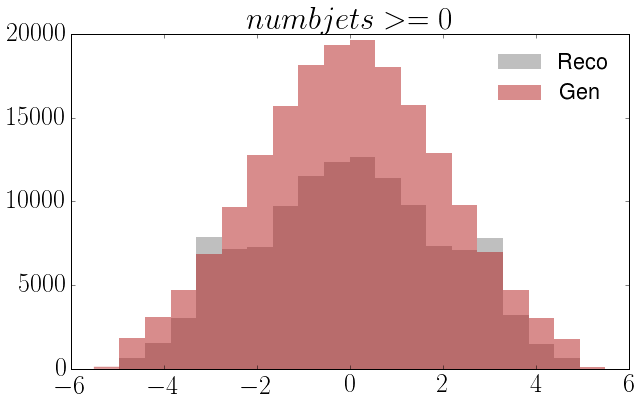

In [14]:
# General Plotting
query = "numb_jets >= 0"
matplotlib.rcParams.update({'font.size': 26})
plt.figure(figsize=(10,6))
plt.hist(df.query(query).jet1_eta, bins=20, color=[.5, .5, .5 , .5], range=(-5.5, 5.5), edgecolor="none", label="Reco")
plt.hist(df.query(query).genjet1_eta, bins=20, color=[.7, .1, .1, .5], range=(-5.5, 5.5),  edgecolor="none", label="Gen" )
plt.title( "$"+" ".join(query.split("_"))+"$" )
plt.legend(framealpha=0.5, fontsize="small", frameon=False)
plt.show()

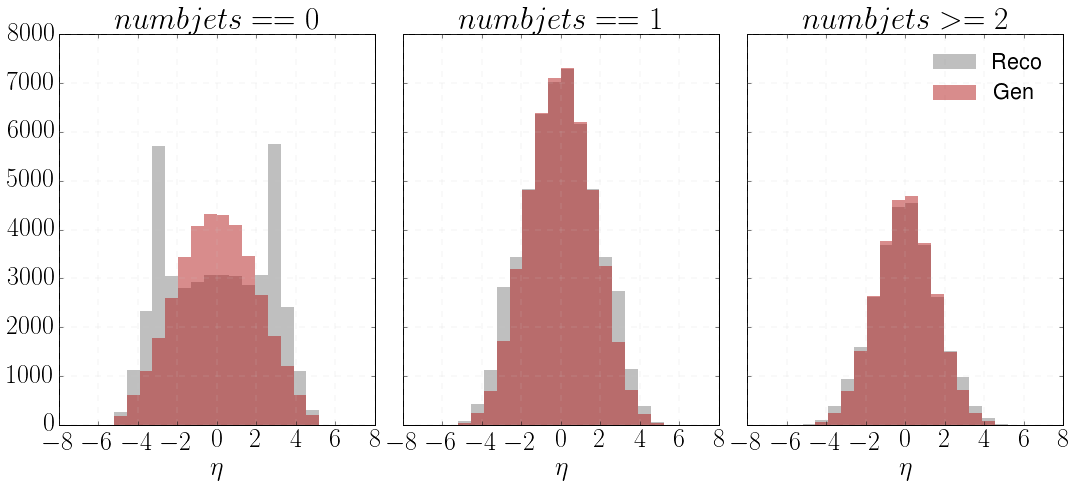

In [15]:
# Number of Reco Jet plot
fig, ax = plt.subplots(1, 3, figsize=(18,7), sharey=True )
fig.subplots_adjust(wspace=0.09)
#fig.suptitle("$\eta$", fontsize=48, y =1)
for it, cut in enumerate(["numb_jets == 0","numb_jets == 1","numb_jets >= 2"]):
    ax[it].grid(color=(0.8,0.8,0.8), alpha=0.1, linestyle='--', linewidth=2)
    ax[it].hist(df.query(cut).jet1_eta.values, range=(-6.5, 6.5), color=[.5, .5, .5 , .5], bins=20, edgecolor="none", label="Reco")
    ax[it].hist(df.query(cut + "& genjet1_pt > 15").genjet1_eta.values, range=(-6.5, 6.5), color=[.7, .1, .1 , .5], bins=20, edgecolor="none", label="Gen")
    ax[it].set_title("$"+" ".join(cut.split("_"))+"$")
    ax[it].set_xlabel("$\eta$")
    
plt.legend(ax[2].get_legend_handles_labels()[0], ax[2].get_legend_handles_labels()[1], framealpha=0.5, fontsize="small", frameon=False)
plt.show()

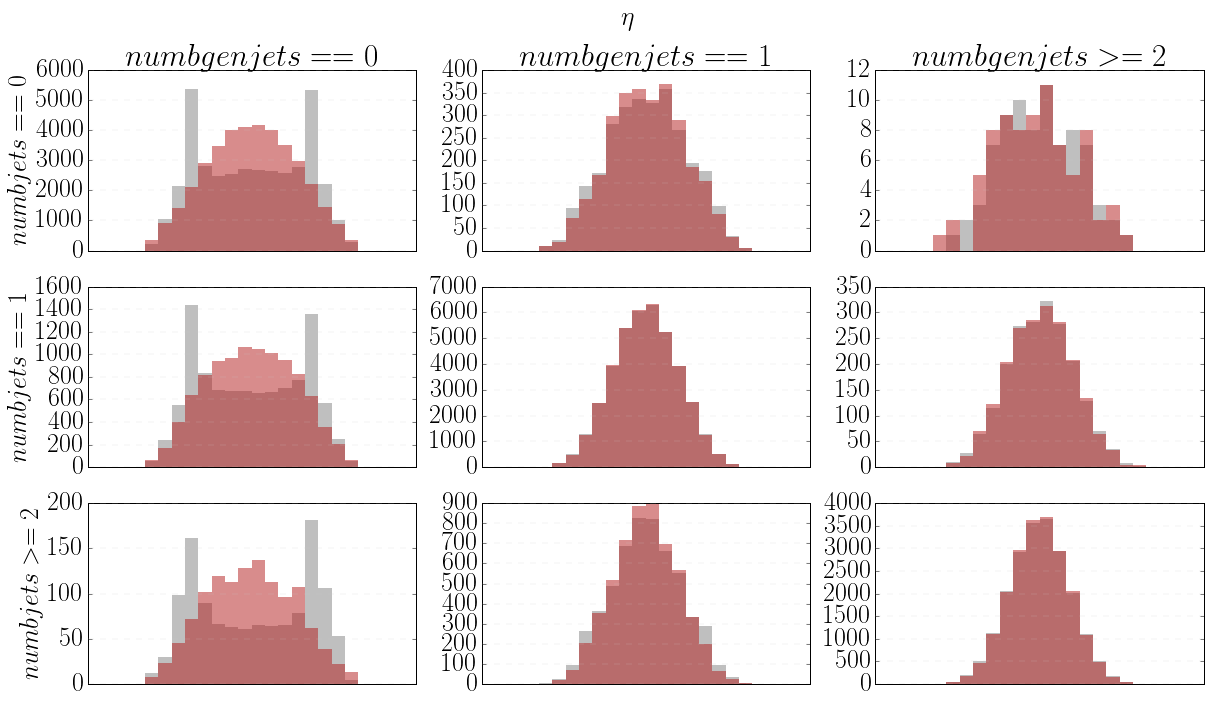

In [16]:
#eta plots for matrix
fig, ax = plt.subplots(3, 3, figsize=(20,11))
fig.subplots_adjust(wspace=0.2, hspace=0.2)
fig.suptitle("$\eta$")
query = "jet1_pt > -99 & genjet1_pt > -99"
for it, cut_i in enumerate(["numb_jets == 0","numb_jets == 1","numb_jets >= 2"]):
    for jt, cut_j in enumerate(["numb_gen_jets == 0","numb_gen_jets == 1","numb_gen_jets >= 2"]):
        ax[it][jt].grid(color=(0.8,0.8,0.8), alpha=0.1, linestyle='--', linewidth=2)
        ax[it][jt].hist(df.query(query + " & " + cut_i + " & " + cut_j).jet1_eta.values, range=(-6.5, 6.5), color=[.5, .5, .5 , .5], bins=20, edgecolor="none")
        ax[it][jt].hist(df.query(query + " & " + cut_i + " & " + cut_j).genjet1_eta.values, range=(-6.5, 6.5), color=[.7, .1, .1 , .5], bins=20, edgecolor="none")
        ax[it][jt].axes.get_xaxis().set_ticks([])
        if jt == 0:
            ax[it][jt].set_ylabel("$"+" ".join(cut_i.split("_"))+"$")
        if it == 0:
            ax[it][jt].set_title("$"+" ".join(cut_j.split("_"))+"$")

    
plt.show()

# Are Reco Jets being matched to Gen jets

Studies on $\Delta$R and $\Delta$Pt. 

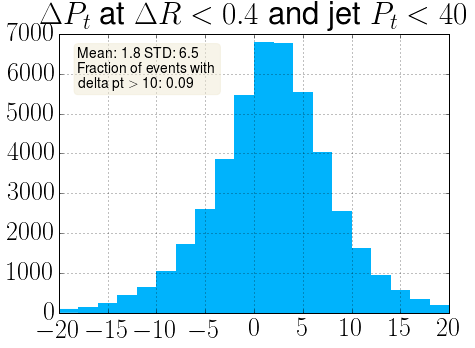

In [43]:
#delta pt
props = dict(boxstyle='round', facecolor=[.94, .918, .83], alpha=0.5, edgecolor=[.94, .918, .83])
query = "dR_gj_rj < 0.4 & jet1_pt < 40 & jet1_pt > 20"

mean = (df_ww.query(query).jet1_pt -\
        df_ww.query(query).genjet1_pt).mean()
std = (df_ww.query(query).jet1_pt -\
        df_ww.query(query).genjet1_pt).std()
delta_pt = df_ww.query(query).jet1_pt -\
df_ww.query(query).genjet1_pt
frac= "Fraction of events with\n delta pt $>$ 10: "+  str(round(float(delta_pt[delta_pt>10].shape[0])/\
df_ww.query(query).dPT.shape[0], 2))

a =df_ww.query(query).dPT.hist(range=(-20, 20), bins=20,\
                                                     color=[0, .7, .99], edgecolor="none",\
                                                     figsize=(7.,5.))

s = "Mean: " + str(round(mean, 2)) + " STD: "+ str(round(std, 2))  + "\n"+ frac
plt.text(0.05, 0.95, s , fontsize=14, transform=a.transAxes,
        verticalalignment='top', bbox=props, )
plt.title("$\Delta P_t$ at $\Delta R < 0.4$ and jet $P_t < 40$ ")

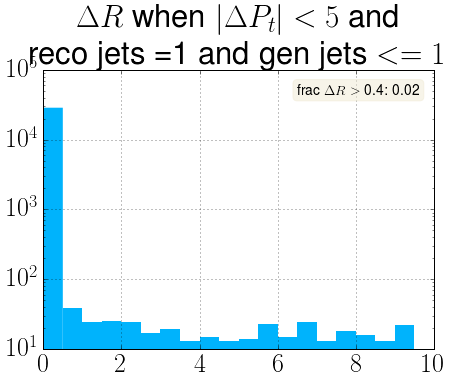

In [18]:
#Plot DR for jet close in pt
a = df_ww.query("dPT < 5 & dPT > -5 & " +\
            "numb_gen_jets <= 1 & " +\
            "numb_jets == 1").dR_gj_rj.hist(range=(0,10),bins=20,\
                                            color=[0, .7, .99], edgecolor="none",
                                            log=True, figsize=(7.,5.))
props = dict(boxstyle='round', facecolor=[.94, .918, .83], alpha=0.5, edgecolor=[.94, .918, .83])
# Strings
n = float(df_ww.query("dPT < 5 & dPT > -5 & numb_gen_jets <= 1 & dR_gj_rj > 0.4 & numb_jets ==1").dR_gj_rj.shape[0]) /\
df_ww.query("dPT < 5 & dPT > -5 & numb_gen_jets <= 1 & numb_jets==1").dR_gj_rj.shape[0]
s = "frac $\Delta R>$ 0.4: " + str(round(n, 2))
plt.text(0.65, 0.95, s , fontsize=14, transform=a.transAxes,
        verticalalignment='top', bbox=props, )

plt.title("$\Delta R$ when $|\Delta P_t| < 5$ and\n reco jets =1 and gen jets $<=1$ ")

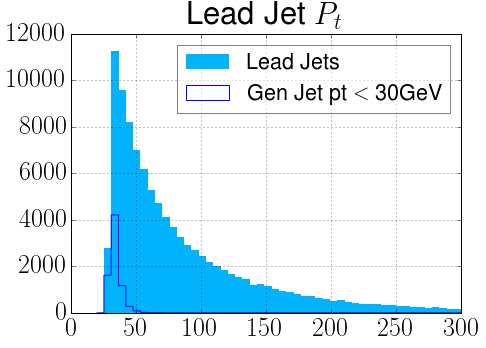

In [36]:
#Lead reco pt
props = dict(boxstyle='round', facecolor=[.94, .918, .83], alpha=0.5, edgecolor=[.94, .918, .83])
mean = (df_ww.query("dR_gj_rj < 0.4 & jet1_pt < 40").jet1_pt - df_ww.query("dR_gj_rj < 0.4 & jet1_pt < 40").genjet1_pt).mean()
delta_pt = df_ww.query("dR_gj_rj < 0.4 & jet1_pt < 40").jet1_pt - df_ww.query("dR_gj_rj < 0.4 & jet1_pt < 40").genjet1_pt
frac= "Fraction of events with\n delta pt $>$ 10: "+  str(round(float(delta_pt[delta_pt>10].shape[0])/\
df_ww.query("dR_gj_rj < 0.4 & jet1_pt < 40").dPT.shape[0], 2))

df_ww.query("dR_gj_rj < 0.4 & jet1_pt >= 30").jet1_pt.hist(range=(20,300), bins=50,\
                                                     color=[0, .7, .99], edgecolor="none",\
                                                     figsize=(7.,5.), label="Lead Jets")
a =df_ww.query("dR_gj_rj < 0.4 & genjet1_pt < 30 & jet1_pt >= 30").jet1_pt.hist(range=(20,300), bins=50,\
                                                     color=[0, 0.0, .99],\
                                                     figsize=(7.,5.), histtype='step', label="Gen Jet pt $<$ 30GeV")

s = "Mean: " + str(round(mean, 2)) +"\n"+ frac
#plt.text(0.05, 0.95, s , fontsize=14, transform=a.transAxes,
#        verticalalignment='top', bbox=props, )
plt.legend(a.get_legend_handles_labels()[0], a.get_legend_handles_labels()[1], framealpha=0.5, fontsize="small", )
plt.title("Lead Jet $P_t$")

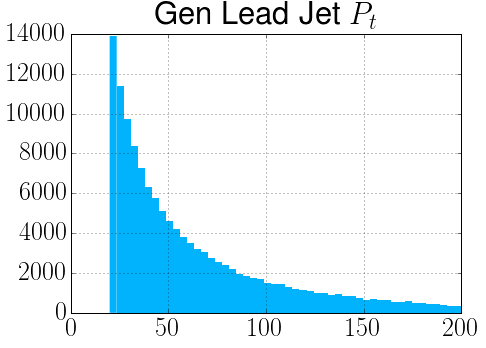

In [70]:
#Gen reco pt
props = dict(boxstyle='round', facecolor=[.94, .918, .83], alpha=0.5, edgecolor=[.94, .918, .83])
mean = (df_ww.query("dR_gj_rj < 0.4 & jet1_pt < 40").jet1_pt - df_ww.query("dR_gj_rj < 0.4 & jet1_pt < 40").genjet1_pt).mean()
delta_pt = df_ww.query("dR_gj_rj < 0.4 & jet1_pt < 40").jet1_pt - df_ww.query("dR_gj_rj < 0.4 & jet1_pt < 40").genjet1_pt
frac= "Fraction of events with\n delta pt $>$ 10: "+  str(round(float(delta_pt[delta_pt>10].shape[0])/\
df_ww.query("dR_gj_rj < 0.4 & jet1_pt < 40").dPT.shape[0], 2))

df_ww.query("dR_gj_rj > -1").genjet1_pt.hist(range=(20,200), bins=50,\
                                                     color=[0, .7, .99], edgecolor="none",\
                                                     figsize=(7.,5.), label="Lead Jets")

s = "Mean: " + str(round(mean, 2)) +"\n"+ frac
#plt.text(0.05, 0.95, s , fontsize=14, transform=a.transAxes,
#        verticalalignment='top', bbox=props, )
#plt.legend(a.get_legend_handles_labels()[0], a.get_legend_handles_labels()[1], framealpha=0.5, fontsize="small", )
plt.xlim((0,200))
plt.title("Gen Lead Jet $P_t$")

# Gen == 0 Reco == 1 matrix element

In [19]:
# Colors
delta_c = [0, .7, .99]
reco_c  = [0.5, 0, .99]
gen_c   = [0.99, 0.5, 0]

## pt

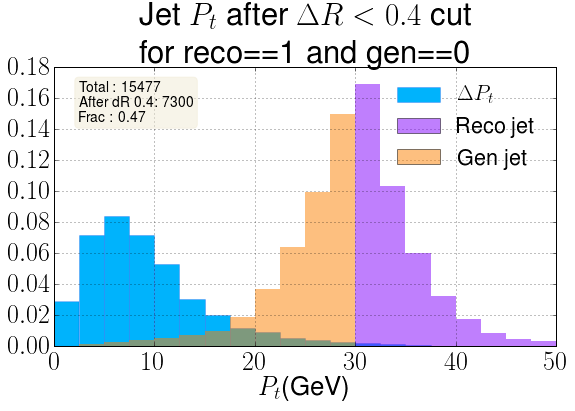

In [20]:
# Momentum histograms Strict delta R
query = "dR_gj_rj < 0.4 & numb_jets == 1 & numb_gen_jets == 0"
a =(df_ww.query(query).jet1_pt - df_ww.query(query).genjet1_pt).hist(range=(0, 50), bins=20,\
                                                                     normed=True, color=delta_c, edgecolor=[0,.12,.9, 0.2],\
                                                                     figsize=(9.,5.), label="$\Delta P_{t}$")
b = df_ww.query(query).jet1_pt.hist(bins=20, range=(0, 50), alpha=.5, color=reco_c, normed=True, edgecolor="none", label="Reco jet")
c= df_ww.query(query).genjet1_pt.hist(bins=20, range=(0, 50), alpha=.5, color=gen_c, normed=True, edgecolor="none", label="Gen jet")


props = dict(boxstyle='round', facecolor=[.94, .918, .83], alpha=0.5, edgecolor=[.94, .918, .83])
# Strict delta R stats
post_dR = df_ww.query(query).shape[0]
reco_1_gen_0 = df_ww.query("numb_jets == 1 & numb_gen_jets == 0").shape[0]
s =  "Total : " + str(reco_1_gen_0) +\
    "\nAfter dR 0.4: " + str(post_dR) +\
    "\nFrac : " + str(round(float(post_dR)/reco_1_gen_0,2))
plt.text(0.05, 0.95, s , fontsize=14, transform=c.transAxes,
        verticalalignment='top', bbox=props, )
plt.legend(c.get_legend_handles_labels()[0], c.get_legend_handles_labels()[1], framealpha=0.5, fontsize="small", frameon=False)
plt.title("Jet $P_t$ after $\Delta R < 0.4$ cut\n for reco==1 and gen==0 ")
plt.xlabel("$P_t$(GeV)")
plt.ylabel("")

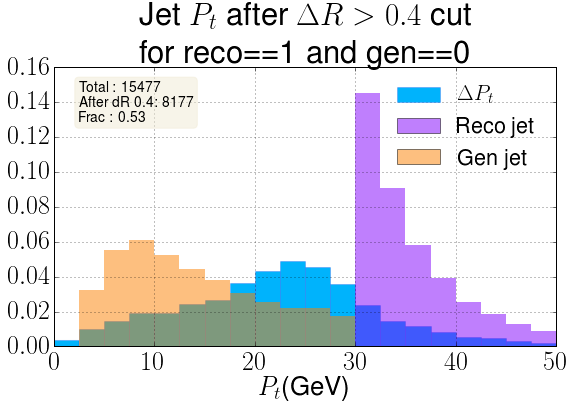

In [21]:
# Momentum histograms Invert delta R
query = "dR_gj_rj > 0.4 & numb_jets == 1 & numb_gen_jets == 0"
a =(df_ww.query(query).jet1_pt - df_ww.query(query).genjet1_pt).hist(range=(0, 50), bins=20,\
                                                                     normed=True, color=delta_c, edgecolor=[0,.12,.9, 0.2],\
                                                                     figsize=(9.,5.), label="$\Delta P_{t}$")
b = df_ww.query(query).jet1_pt.hist(bins=20, range=(0, 50), alpha=.5, color=reco_c, normed=True,  edgecolor="none", label="Reco jet")
c= df_ww.query(query).genjet1_pt.hist(bins=20, range=(0, 50), alpha=.5, color=gen_c, normed=True,  edgecolor="none", label="Gen jet")


props = dict(boxstyle='round', facecolor=[.94, .918, .83], alpha=0.5, edgecolor=[.94, .918, .83])
# Invert delta R stats
post_dR = df_ww.query(query).shape[0]
reco_1_gen_0 = df_ww.query("numb_jets == 1 & numb_gen_jets == 0").shape[0]
s =  "Total : " + str(reco_1_gen_0) +\
    "\nAfter dR 0.4: " + str(post_dR) +\
    "\nFrac : " + str(round(float(post_dR)/reco_1_gen_0, 2))
plt.text(0.05, 0.95, s , fontsize=14, transform=c.transAxes,
        verticalalignment='top', bbox=props, )
plt.legend(c.get_legend_handles_labels()[0], c.get_legend_handles_labels()[1], framealpha=0.5, fontsize="small", frameon=False)
plt.title("Jet $P_t$ after $\Delta R > 0.4$ cut\n for reco==1 and gen==0 ")
plt.xlabel("$P_t$(GeV)")

## eta

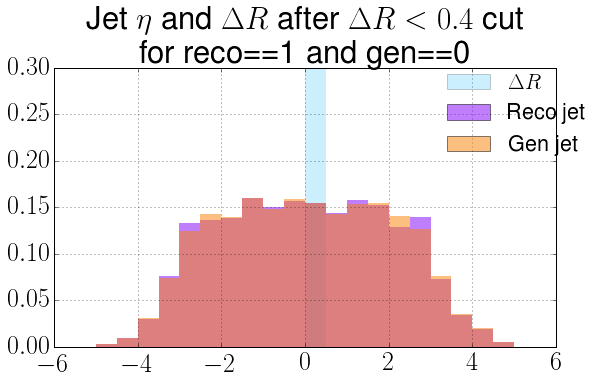

In [22]:
# Eta histograms Strict delta R
query = "dR_gj_rj < 0.4 & numb_jets == 1 & numb_gen_jets == 0"
a =df_ww.query(query).dR_gj_rj.hist(range=(-5.5, 5.5), bins=22,\
                                    alpha=0.2, normed=True, color=delta_c, edgecolor="none",\
                                    figsize=(9.,5.), label="$\Delta R$")
b = df_ww.query(query).jet1_eta.hist(bins=22, range=(-5.5, 5.5), alpha=.5, color=reco_c, normed=True, label="Reco jet", edgecolor="none")
c= df_ww.query(query).genjet1_eta.hist(bins=22, range=(-5.5, 5.5), alpha=.5, color=gen_c, normed=True, label="Gen jet", edgecolor="none")

plt.ylim(0,.3)
props = dict(boxstyle='round', facecolor=[.94, .918, .83], alpha=0.5, edgecolor=[.94, .918, .83])
# Invert delta R stats
post_dR = df_ww.query(query).shape[0]
reco_1_gen_0 = df_ww.query("numb_jets == 1 & numb_gen_jets == 0").shape[0]
s =  "Total : " + str(reco_1_gen_0) +\
    "\nAfter dR 0.4: " + str(post_dR) +\
    "\nFrac : " + str(float(post_dR)/reco_1_gen_0)
#plt.text(0.05, 0.95, s , fontsize=14, transform=c.transAxes,
#        verticalalignment='top', bbox=props, )
plt.legend(c.get_legend_handles_labels()[0], c.get_legend_handles_labels()[1], framealpha=0.5, fontsize="small", frameon=False, bbox_to_anchor=(1.1, 1.05))
plt.title("Jet $\eta$ and $\Delta R$ after $\Delta R < 0.4$ cut\n for reco==1 and gen==0 ")

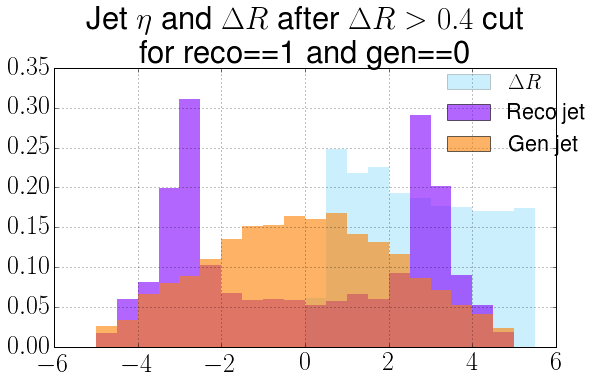

In [23]:
# Eta histograms Invert delta R
query = "dR_gj_rj > 0.4 & numb_jets == 1 & numb_gen_jets == 0"
a =df_ww.query(query).dR_gj_rj.hist(range=(-5.5, 5.5), bins=22,\
                                    alpha=0.2, normed=True, color=[0, .7, .99], edgecolor="none",\
                                    figsize=(9.,5.), label="$\Delta R$", grid=False)
b = df_ww.query(query).jet1_eta.hist(bins=22, range=(-5.5, 5.5), alpha=.6, color=[0.5, 0, .99], normed=True, label="Reco jet", grid=False,edgecolor="none")
c= df_ww.query(query).genjet1_eta.hist(bins=22, range=(-5.5, 5.5), alpha=.6, color=[0.99, 0.5, 0], normed=True, label="Gen jet",edgecolor="none")


props = dict(boxstyle='round', facecolor=[.94, .918, .83], alpha=0.5, edgecolor=[.94, .918, .83])
# Invert delta R stats
post_dR = df_ww.query(query).shape[0]
reco_1_gen_0 = df_ww.query("numb_jets == 1 & numb_gen_jets == 0").shape[0]
s =  "Total : " + str(reco_1_gen_0) +\
    "\nAfter dR 0.4: " + str(post_dR) +\
    "\nFrac : " + str(float(post_dR)/reco_1_gen_0)
#plt.text(0.05, 0.95, s , fontsize=14, transform=c.transAxes,
#        verticalalignment='top', bbox=props, )
plt.legend(c.get_legend_handles_labels()[0], c.get_legend_handles_labels()[1], framealpha=0.5, fontsize="small", frameon=False, bbox_to_anchor=(1.1, 1.05))
plt.title("Jet $\eta$ and $\Delta R$ after $\Delta R > 0.4$ cut\n for reco==1 and gen==0 ")

### eta vs pu mva

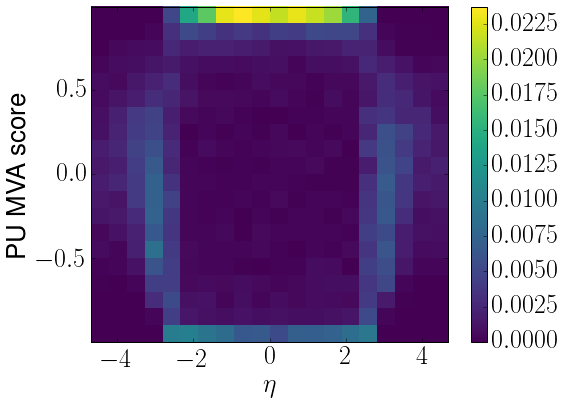

In [55]:
#PU MVA vs eta
matplotlib.rcParams.update({'font.size': 26})
plt.figure(figsize=(8,6))

query = "numb_jets == 1 & numb_gen_jets == 0"
shape = df.query(query).shape[0]
plt.hist2d(df.query(query).jet1_eta.values,
           df.query(query).jet1_pu.values, 
           cmap="viridis", weights=df.query(query).weight.values / float(shape), bins=20)
plt.colorbar()
plt.ylabel("PU MVA score")
plt.xlabel("$\eta$")
plt.show()

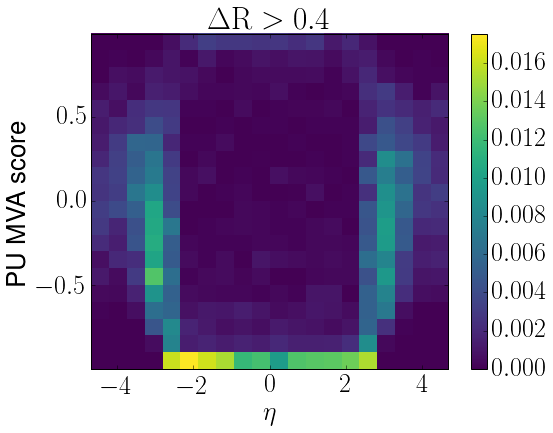

In [61]:
#PU MVA vs eta
matplotlib.rcParams.update({'font.size': 26})
plt.figure(figsize=(8,6))

query = "numb_jets == 1 & numb_gen_jets == 0 & dR_gj_rj > 0.4"
shape = df.query(query).shape[0]
plt.hist2d(df.query(query).jet1_eta.values,
           df.query(query).jet1_pu.values, 
           cmap="viridis", weights=df.query(query).weight.values / float(shape), bins=20)
plt.colorbar()
plt.ylabel("PU MVA score")
plt.xlabel("$\eta$")
plt.title("$\Delta \mathrm{R} > 0.4$")
plt.show()

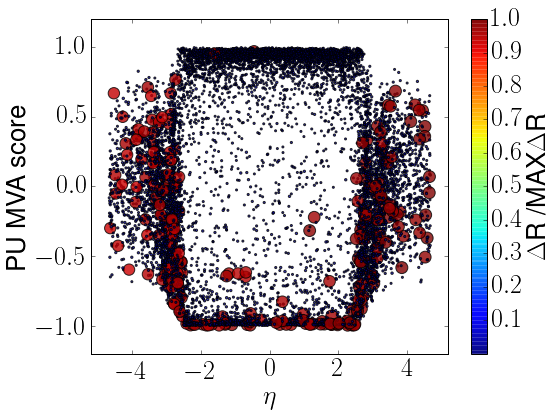

In [170]:
#PU MVA vs eta vs dR
matplotlib.rcParams.update({'font.size': 26})
plt.figure(figsize=(8,6))
dR = df[(df.numb_jets == 1) & (df.numb_gen_jets == 0)].dR_gj_rj.values /\
            df[(df.numb_jets == 1) & (df.numb_gen_jets == 0)].dR_gj_rj.values.max()
    
plt.scatter(x=df[(df.numb_jets == 1) & (df.numb_gen_jets == 0)].jet1_eta.values,
           y=df[(df.numb_jets == 1) & (df.numb_gen_jets == 0)].jet1_pu.values, 
           c=dR,
           s=(10*dR+2)**2., alpha=0.8)
cbar = plt.colorbar()
cbar.set_label('$\Delta$R /MAX$\Delta$R ')
plt.ylim((-1.2, 1.2))
plt.xlim((-5.2, 5.2))

plt.ylabel("PU MVA score")
plt.xlabel("$\eta$")
plt.show()

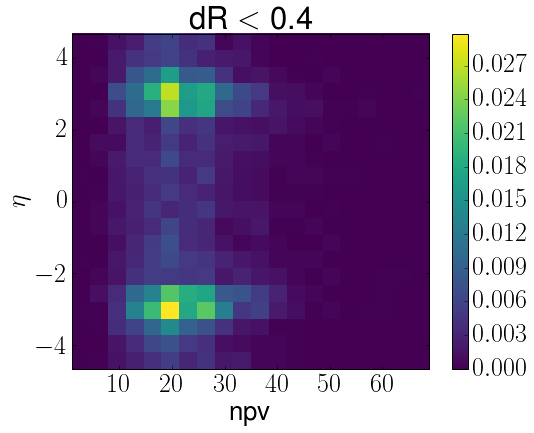

In [62]:
#PU MVA vs npv
matplotlib.rcParams.update({'font.size': 26})
plt.figure(figsize=(8,6))
query = "numb_jets == 1 & numb_gen_jets == 0 & dR_gj_rj > 0.4"
shape = df.query(query).shape[0]
plt.hist2d(df.query(query).tot_npv.values,
           df.query(query).jet1_eta.values, 
           cmap="viridis", weights=np.ones(shape) / float(shape), bins=20)
plt.colorbar()
plt.ylabel("$\eta$")
plt.xlabel("npv")
plt.title("dR $<$ 0.4")
plt.show()

## PU

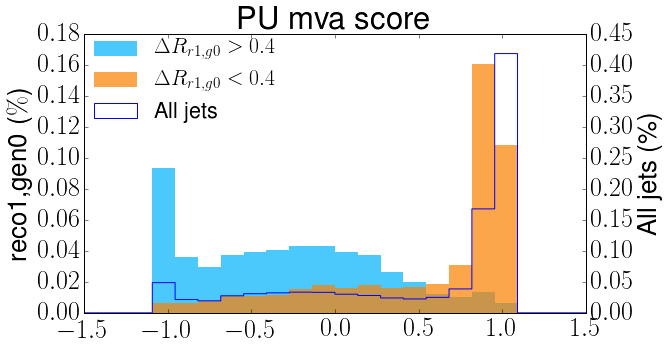

In [24]:
# Eta histograms Invert delta R
query = "dR_gj_rj > 0.4 & numb_jets == 1 & numb_gen_jets == 0 & jet1_pu > -10"
a =df_ww.query(query).jet1_pu.hist(range=(-1.5, 1.5), bins=22,\
                                    weights=np.ones(df_ww.query(query).shape[0])/df_ww.query("numb_jets == 1 & numb_gen_jets == 0").shape[0],\
                                   color=[0, .7, .99, 0.7], edgecolor="none",\
                                    figsize=(9.,5.), label="$\Delta R_{r1,g0} > 0.4$", grid=False)
query = "dR_gj_rj < 0.4 & numb_jets == 1 & numb_gen_jets == 0 & jet1_pu > -10"
b =df_ww.query(query).jet1_pu.hist(range=(-1.5, 1.5), bins=22,\
                                    weights=np.ones(df_ww.query(query).shape[0])/df_ww.query("numb_jets == 1 & numb_gen_jets == 0").shape[0],\
                                   color=[0.99, 0.5, 0, 0.7], edgecolor="none",\
                                    figsize=(9.,5.), label="$\Delta R_{r1,g0} < 0.4$", grid=False)
c =df_ww.jet1_pu.plot(secondary_y=True, ax=b, kind="hist", range=(-1.5, 1.5), bins=22,\
                                    weights=np.ones(df_ww.shape[0])/df_ww.query("jet1_pu > -10").shape[0],\
                                    histtype='step',\
                                    figsize=(9.,5.), label="All jets")



b.set_ylabel("reco1,gen0 ($\%$)")
c.set_ylabel("All jets (\%)")
plt.legend(b.get_legend_handles_labels()[0] + c.get_legend_handles_labels()[0] ,\
           b.get_legend_handles_labels()[1] + c.get_legend_handles_labels()[1], framealpha=0.5,\
           fontsize="small", frameon=False, bbox_to_anchor=(0.42, 1.05))
plt.title("PU mva score")

In [25]:
query = " jet1_pu > -10"
query_ = "& jet1_pu > -0.0"

print "a", df_ww.query(query + query_).shape[0],\
float(df_ww.query(query + query_).shape[0]) / df_ww.query(query).shape[0]

query += "& numb_jets == 1 & numb_gen_jets == 0 "
print df_ww.query(query + query_).shape[0],\
float(df_ww.query(query + query_).shape[0]) / df_ww.query(query).shape[0]

a 136682 0.753658509688
8508 0.549718937779


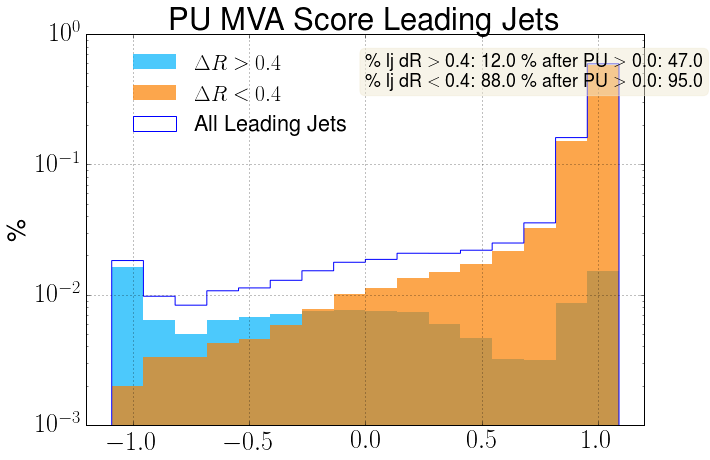

In [26]:
# Eta histograms Invert delta R
query = "dR_gj_rj > 0.4 & numb_jets >= 1 & jet1_pu > -10"
a =df_ww.query(query).jet1_pu.hist(range=(-1.5, 1.5), bins=22,\
                                    weights=np.ones(df_ww.query(query).shape[0])/df_ww.query("numb_jets >= 1 & jet1_pu > -10").shape[0],\
                                   color=[0, .7, .99, 0.7], edgecolor="none",\
                                    figsize=(10.,7.), label="$\Delta R > 0.4$", grid=False)
query = "dR_gj_rj < 0.4 & numb_jets >= 1  & jet1_pu > -10"
b =df_ww.query(query).jet1_pu.hist(range=(-1.5, 1.5), bins=22,\
                                    weights=np.ones(df_ww.query(query).shape[0])/df_ww.query("numb_jets >= 1 & jet1_pu > -10").shape[0],\
                                   color=[0.99, 0.5, 0, 0.7], edgecolor="none",\
                                    figsize=(10.,7.), label="$\Delta R < 0.4$", grid=False)
c =df_ww.query("numb_jets >= 1").jet1_pu.hist( range=(-1.5, 1.5), bins=22,\
                               weights=np.ones(df_ww.query("numb_jets >= 1").shape[0])/df_ww.query(" numb_jets >= 1 & jet1_pu > -10").shape[0],\
                                    histtype='step',\
                                    figsize=(10.,7.), label="All Leading Jets")


props = dict(boxstyle='round', facecolor=[.94, .918, .83], alpha=0.5, edgecolor=[.94, .918, .83])
# Invert delta R stats
gt_dr = df_ww.query("dR_gj_rj > 0.4 & numb_jets >= 1 & jet1_pu > -10").shape[0]
gt_dr_pu = df_ww.query("dR_gj_rj > 0.4 & numb_jets >= 1 & jet1_pu > -0.0").shape[0]

lt_dr = df_ww.query("dR_gj_rj < 0.4 & numb_jets >= 1 & jet1_pu > -10").shape[0]
lt_dr_pu = df_ww.query("dR_gj_rj < 0.4 & numb_jets >= 1 & jet1_pu > -0.0").shape[0]

lj = df_ww.query("numb_jets >= 1 & jet1_pu > -10").shape[0]

s =  " \% lj dR $>$ 0.4: " + str(round(float(gt_dr)/lj ,2)*100) + " \% after PU $>$ 0.0: " + str(round(float(gt_dr_pu)/gt_dr,2)*100) +\
    "\n\% lj dR $<$ 0.4: " + str(round(float(lt_dr)/lj,2)*100) + " \% after PU $>$ 0.0: " + str(round(float(lt_dr_pu)/lt_dr,2)*100) 
plt.text(0.5, 0.95, s , fontsize=18, transform=c.transAxes,
        verticalalignment='top', bbox=props, )


c.set_yscale("log")
c.set_xlim(-1.2, 1.2)
c.set_ylabel("\%")
plt.legend(c.get_legend_handles_labels()[0] ,\
           c.get_legend_handles_labels()[1], framealpha=0.5,\
           fontsize="small", frameon=False, bbox_to_anchor=(0.50, 1.0))
plt.title("PU MVA Score Leading Jets")

# PU MVA MC/Data

In [63]:
df_da = rp.read_root("../data/gen_jets/Da_Da_99.root")
df_da = pre_cuts(df_da[df_da.metMod > 50])

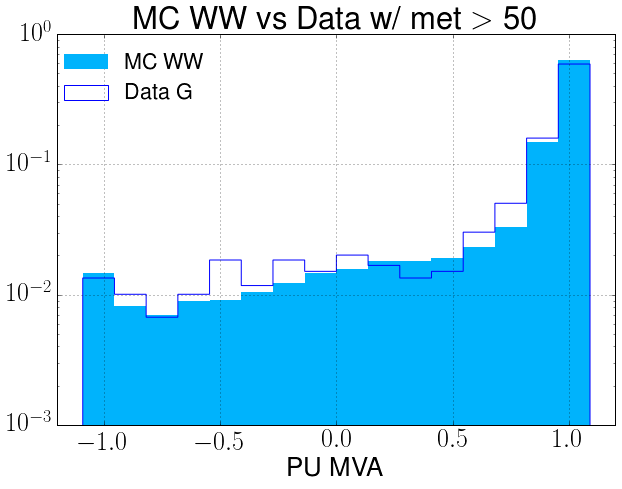

In [152]:
#PU MC vs Data test
query = "numb_jets >= 1 & jet1_pu > -10"
df_ww.query(query + " & metMod > 50").jet1_pu.hist(range=(-1.5, 1.5), bins=22,\
                                    weights=np.ones(df_ww.query(query + " & metMod > 50").shape[0])/df_ww.query(query + " & metMod > 50").shape[0],\
                                   color=[0, .7, .99], edgecolor="none",\
                                    figsize=(10.,7.), label="MC WW", grid=False)
a = df_da.query(query).jet1_pu.hist(range=(-1.5, 1.5), bins=22,\
                                       weights=np.ones(df_da.query(query).shape[0])/df_da.query(query).shape[0],\
                               histtype='step', label="Data G")
a.set_yscale("log")
plt.xlim((-1.2, 1.2))
plt.title("MC WW vs Data w/ met $>$ 50")
plt.xlabel("PU MVA")
plt.legend(a.get_legend_handles_labels()[0] ,\
           a.get_legend_handles_labels()[1], framealpha=0.5,\
           fontsize="small", frameon=False, bbox_to_anchor=(0.3, 1.0))

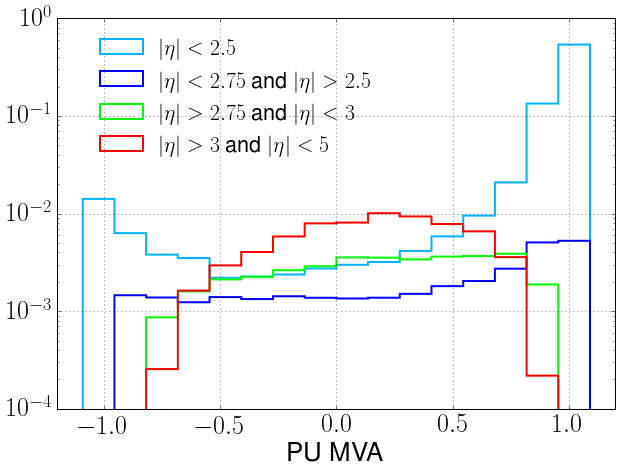

In [34]:
#PU MC vs Data test
#0-2.5, 2.5-2.75, 2.75-3.0, 3.0-5.0
matplotlib.rcParams.update({'font.size': 26})
q_1 = "numb_jets >= 1 & jet1_pu > -10"
query = "numb_jets >= 1 & jet1_pu > -10 & jet1_eta > -2.5 & jet1_eta < 2.5"
df_ww.query(query ).jet1_pu.hist(range=(-1.5, 1.5), bins=22,\
                                    weights=df_ww.query(query).weight.values/df_ww.query(q_1).shape[0],\
                                   color=[0, .7, .99],\
                                    figsize=(10.,7.), label="$|\eta| < 2.5$", histtype='step', grid=True, linewidth=2)
query = "numb_jets >= 1 & jet1_pu > -10 & ( (jet1_eta > -2.7 & jet1_eta < -2.5) | (jet1_eta < 2.7 & jet1_eta > 2.5) )"
df_ww.query(query ).jet1_pu.hist(range=(-1.5, 1.5), bins=22,\
                                    weights=df_ww.query(query).weight.values/df_ww.query(q_1).shape[0],\
                                   color=[0, 0, .99],\
                                    figsize=(10.,7.), label="$|\eta| < 2.75$ and $|\eta| > 2.5$", histtype='step', grid=True, linewidth=2)
query = "numb_jets >= 1 & jet1_pu > -10 & ( (jet1_eta > -3 & jet1_eta < -2.75) | (jet1_eta < 3 & jet1_eta > 2.75) )"
df_ww.query(query ).jet1_pu.hist(range=(-1.5, 1.5), bins=22,\
                                    weights=df_ww.query(query).weight.values/df_ww.query(q_1).shape[0],\
                                   color=[0, 0.99, 0],\
                                    figsize=(10.,7.), label="$|\eta| > 2.75$ and $|\eta| < 3$", histtype='step', grid=True, linewidth=2)
query = "numb_jets >= 1 & jet1_pu > -10 & ( (jet1_eta > -5 & jet1_eta < -3) | (jet1_eta < 5 & jet1_eta > 3) )"
a = df_ww.query(query ).jet1_pu.hist(range=(-1.5, 1.5), bins=22,\
                                    weights=df_ww.query(query).weight.values/df_ww.query(q_1).shape[0],\
                                   color=[0.99, 0, 0],\
                                    figsize=(10.,7.), label="$|\eta| > 3$ and $|\eta| < 5$", histtype='step', grid=True, linewidth=2)

a.set_yscale("log")
plt.xlim((-1.2, 1.2))
plt.ylim((10e-5, 1))
plt.title("")
plt.xlabel("PU MVA")
plt.legend(a.get_legend_handles_labels()[0] ,\
           a.get_legend_handles_labels()[1], framealpha=0.5,\
           fontsize="small", frameon=False, bbox_to_anchor=(0.6, 1.0))

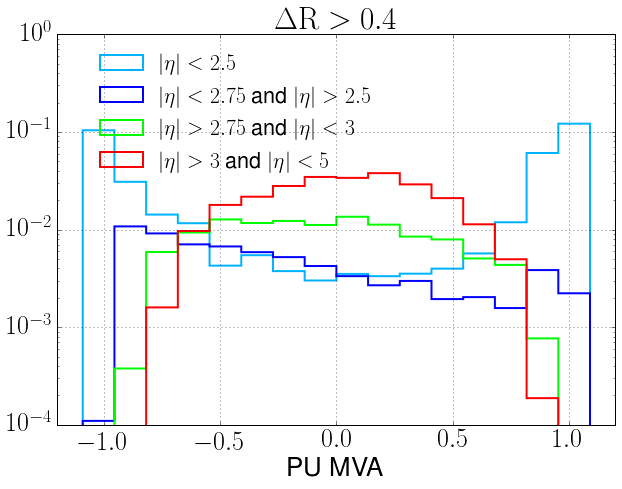

In [32]:
#dR > 0.4
matplotlib.rcParams.update({'font.size': 26})
q_1 = "numb_jets >= 1 & jet1_pu > -10 & dR_gj_rj > 0.4"
query = "numb_jets >= 1 & jet1_pu > -10 & jet1_eta > -2.5 & jet1_eta < 2.5 & dR_gj_rj > 0.4"
df_ww.query(query ).jet1_pu.hist(range=(-1.5, 1.5), bins=22,\
                                    weights=df_ww.query(query).weight.values/df_ww.query(q_1).shape[0],\
                                   color=[0, .7, .99],\
                                    figsize=(10.,7.), label="$|\eta| < 2.5$", histtype='step', grid=True, linewidth=2)
query = "numb_jets >= 1 & jet1_pu > -10 & ( (jet1_eta > -2.7 & jet1_eta < -2.5) | (jet1_eta < 2.7 & jet1_eta > 2.5) ) & dR_gj_rj > 0.4"
df_ww.query(query ).jet1_pu.hist(range=(-1.5, 1.5), bins=22,\
                                    weights=df_ww.query(query).weight.values/df_ww.query(q_1).shape[0],\
                                   color=[0, 0, .99],\
                                    figsize=(10.,7.), label="$|\eta| < 2.75$ and $|\eta| > 2.5$", histtype='step', grid=True, linewidth=2)
query = "numb_jets >= 1 & jet1_pu > -10 & ( (jet1_eta > -3 & jet1_eta < -2.75) | (jet1_eta < 3 & jet1_eta > 2.75) ) & dR_gj_rj > 0.4"
df_ww.query(query ).jet1_pu.hist(range=(-1.5, 1.5), bins=22,\
                                    weights=df_ww.query(query).weight.values/df_ww.query(q_1).shape[0],\
                                   color=[0, 0.99, 0],\
                                    figsize=(10.,7.), label="$|\eta| > 2.75$ and $|\eta| < 3$", histtype='step', grid=True, linewidth=2)
query = "numb_jets >= 1 & jet1_pu > -10 & ( (jet1_eta > -5 & jet1_eta < -3) | (jet1_eta < 5 & jet1_eta > 3) ) & dR_gj_rj > 0.4"
a = df_ww.query(query ).jet1_pu.hist(range=(-1.5, 1.5), bins=22,\
                                    weights=df_ww.query(query).weight.values/df_ww.query(q_1).shape[0],\
                                   color=[0.99, 0, 0],\
                                    figsize=(10.,7.), label="$|\eta| > 3$ and $|\eta| < 5$", histtype='step', grid=True, linewidth=2)

a.set_yscale("log")
plt.xlim((-1.2, 1.2))
plt.title("$\Delta \mathrm{R} > 0.4$")
plt.xlabel("PU MVA")
plt.legend(a.get_legend_handles_labels()[0] ,\
           a.get_legend_handles_labels()[1], framealpha=0.5,\
           fontsize="small", frameon=False, bbox_to_anchor=(0.6, 1.0))

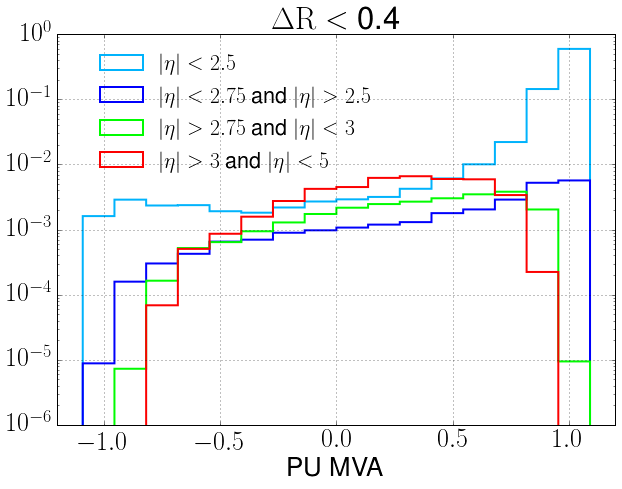

In [35]:
#dR < 0.4
matplotlib.rcParams.update({'font.size': 26})
q_1 = "numb_jets >= 1 & jet1_pu > -10 & dR_gj_rj < 0.4"
query = "numb_jets >= 1 & jet1_pu > -10 & jet1_eta > -2.5 & jet1_eta < 2.5 & dR_gj_rj < 0.4"
df_ww.query(query ).jet1_pu.hist(range=(-1.5, 1.5), bins=22,\
                                    weights=df_ww.query(query).weight.values/df_ww.query(q_1).shape[0],\
                                   color=[0, .7, .99],\
                                    figsize=(10.,7.), label="$|\eta| < 2.5$", histtype='step', grid=True, linewidth=2)
query = "numb_jets >= 1 & jet1_pu > -10 & ( (jet1_eta > -2.7 & jet1_eta < -2.5) | (jet1_eta < 2.7 & jet1_eta > 2.5) ) & dR_gj_rj < 0.4"
df_ww.query(query ).jet1_pu.hist(range=(-1.5, 1.5), bins=22,\
                                    weights=df_ww.query(query).weight.values/df_ww.query(q_1).shape[0],\
                                   color=[0, 0, .99],\
                                    figsize=(10.,7.), label="$|\eta| < 2.75$ and $|\eta| > 2.5$", histtype='step', grid=True, linewidth=2)
query = "numb_jets >= 1 & jet1_pu > -10 & ( (jet1_eta > -3 & jet1_eta < -2.75) | (jet1_eta < 3 & jet1_eta > 2.75) ) & dR_gj_rj < 0.4"
df_ww.query(query ).jet1_pu.hist(range=(-1.5, 1.5), bins=22,\
                                    weights=df_ww.query(query).weight.values/df_ww.query(q_1).shape[0],\
                                   color=[0, 0.99, 0],\
                                    figsize=(10.,7.), label="$|\eta| > 2.75$ and $|\eta| < 3$", histtype='step', grid=True, linewidth=2)
query = "numb_jets >= 1 & jet1_pu > -10 & ( (jet1_eta > -5 & jet1_eta < -3) | (jet1_eta < 5 & jet1_eta > 3) ) & dR_gj_rj < 0.4"
a = df_ww.query(query ).jet1_pu.hist(range=(-1.5, 1.5), bins=22,\
                                    weights=df_ww.query(query).weight.values/df_ww.query(q_1).shape[0],\
                                   color=[0.99, 0, 0],\
                                    figsize=(10.,7.), label="$|\eta| > 3$ and $|\eta| < 5$", histtype='step', grid=True, linewidth=2)

a.set_yscale("log")
plt.xlim((-1.2, 1.2))
plt.title("$\Delta \mathrm{R} <$ 0.4")
plt.xlabel("PU MVA")
plt.legend(a.get_legend_handles_labels()[0] ,\
           a.get_legend_handles_labels()[1], framealpha=0.5,\
           fontsize="small", frameon=False, bbox_to_anchor=(0.6, 1.0))

# PUPPI vs AK4

* Pileup mva is broken for PUPPI container

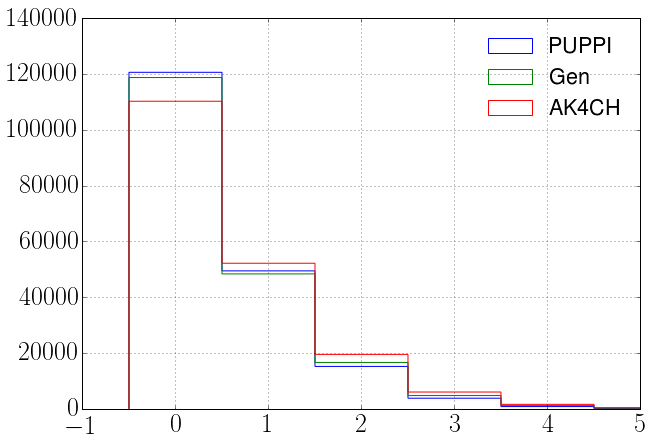

In [83]:
df.numb_puppi_jets.hist(range=(-.5,9.5), bins=10, histtype='step', label="PUPPI")
df.numb_gen_jets.hist(range=(-.5,9.5), bins=10, histtype='step', label="Gen")
a = df.numb_jets.hist(range=(-.5,9.5), bins=10, histtype='step', label="AK4CH",figsize=(10.,7.))

plt.xlim((-1, 5))
plt.legend(a.get_legend_handles_labels()[0] ,\
           a.get_legend_handles_labels()[1], framealpha=0.5,\
           fontsize="small", frameon=False, )

In [84]:
#Weighted matrices
a = []; b = []
reco_matrix = []; matched_matrix = []

for i in range(3):
    a.append([])
    b.append([])
    reco_matrix.append([])
    matched_matrix.append([])
    for j in range(3):
        numb_jets = "numb_puppi_jets == "
        numb_gen_jets = "numb_gen_jets == "
        numb_matched_jets = "numb_matched_jets == "
        if i == 2:
            numb_jets = "numb_puppi_jets >= "
            numb_matched_jets = "numb_matched_jets >= "
        if j == 2:
            numb_gen_jets = "numb_gen_jets >= "
        a[i].append(count_WWs(df.query(numb_jets + str(i) + " & " + numb_gen_jets + str(j))))
        b[i].append(count_WWs(df.query(numb_jets + str(i) + " & " + numb_gen_jets + str(j) + "& numb_matched_jets < " + str(i))))
        
        reco_matrix[i].append(count_WWs(df.query(numb_jets + str(i) + " & " + numb_gen_jets + str(j))) /\
                              count_WWs(df.query(numb_jets + str(i))) )
        matched_matrix[i].append(count_WWs(df.query(numb_matched_jets + str(i) + " & " + numb_gen_jets + str(j))) /\
                                 count_WWs(df.query(numb_matched_jets + str(i))) )

a = np.array(a)
b = np.array(b)
reco_matrix = np.array(reco_matrix)
matched_matrix = np.array(matched_matrix)
nonmatched_matrix = b / a

#print "Non matched: \n", nonmatched_matrix
print "PUPPI Reco: \n", reco_matrix
#print "Matched reco: \n", matched_matrix

PUPPI Reco: 
[[ 0.93668772  0.05951212  0.00380024]
 [ 0.10488302  0.79098584  0.10413103]
 [ 0.00749491  0.11853575  0.87396942]]


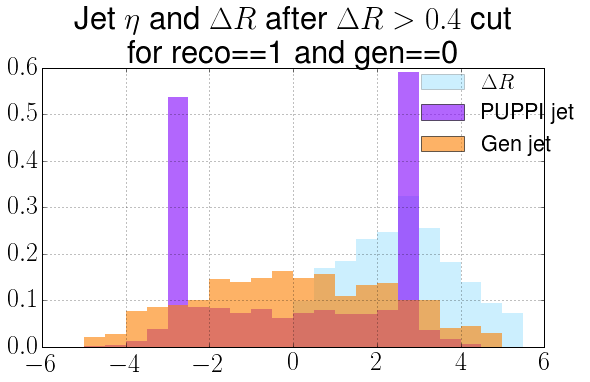

In [98]:
# Eta histograms Invert delta R
query = "dR_gj_puj > 0.4 & numb_puppi_jets == 1 & numb_gen_jets == 0"
a =df_ww.query(query).dR_gj_rj.hist(range=(-5.5, 5.5), bins=22,\
                                    alpha=0.2, normed=True, color=[0, .7, .99], edgecolor="none",\
                                    figsize=(9.,5.), label="$\Delta R$", grid=False)
b = df_ww.query(query).jet1_eta.hist(bins=22, range=(-5.5, 5.5), alpha=.6, color=[0.5, 0, .99], normed=True, label="PUPPI jet", grid=False,edgecolor="none")
c= df_ww.query(query).genjet1_eta.hist(bins=22, range=(-5.5, 5.5), alpha=.6, color=[0.99, 0.5, 0], normed=True, label="Gen jet",edgecolor="none")


props = dict(boxstyle='round', facecolor=[.94, .918, .83], alpha=0.5, edgecolor=[.94, .918, .83])
# Invert delta R stats
post_dR = df_ww.query(query).shape[0]
reco_1_gen_0 = df_ww.query("numb_puppi_jets == 1 & numb_gen_jets == 0").shape[0]
s =  "Total : " + str(reco_1_gen_0) +\
    "\nAfter dR 0.4: " + str(post_dR) +\
    "\nFrac : " + str(float(post_dR)/reco_1_gen_0)
#plt.text(0.05, 0.95, s , fontsize=14, transform=c.transAxes,
#        verticalalignment='top', bbox=props, )
plt.legend(c.get_legend_handles_labels()[0], c.get_legend_handles_labels()[1], framealpha=0.5, fontsize="small", frameon=False, bbox_to_anchor=(1.1, 1.05))
plt.title("Jet $\eta$ and $\Delta R$ after $\Delta R > 0.4$ cut\n for reco==1 and gen==0 ")

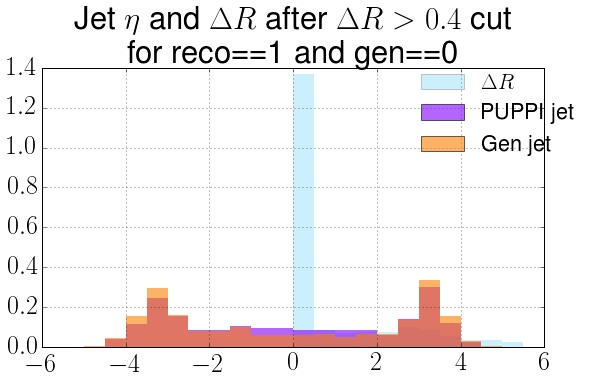

In [97]:
# Eta histograms Invert delta R
query = "dR_gj_puj > 0.4 & numb_puppi_jets == 1 & numb_gen_jets >= 2"
a =df_ww.query(query).dR_gj_rj.hist(range=(-5.5, 5.5), bins=22,\
                                    alpha=0.2, normed=True, color=[0, .7, .99], edgecolor="none",\
                                    figsize=(9.,5.), label="$\Delta R$", grid=False)
b = df_ww.query(query).jet1_eta.hist(bins=22, range=(-5.5, 5.5), alpha=.6, color=[0.5, 0, .99], normed=True, label="PUPPI jet", grid=False,edgecolor="none")
c= df_ww.query(query).genjet1_eta.hist(bins=22, range=(-5.5, 5.5), alpha=.6, color=[0.99, 0.5, 0], normed=True, label="Gen jet",edgecolor="none")


props = dict(boxstyle='round', facecolor=[.94, .918, .83], alpha=0.5, edgecolor=[.94, .918, .83])
# Invert delta R stats
post_dR = df_ww.query(query).shape[0]
reco_1_gen_0 = df_ww.query("numb_puppi_jets == 1 & numb_gen_jets == 0").shape[0]
s =  "Total : " + str(reco_1_gen_0) +\
    "\nAfter dR 0.4: " + str(post_dR) +\
    "\nFrac : " + str(float(post_dR)/reco_1_gen_0)
#plt.text(0.05, 0.95, s , fontsize=14, transform=c.transAxes,
#        verticalalignment='top', bbox=props, )
plt.legend(c.get_legend_handles_labels()[0], c.get_legend_handles_labels()[1], framealpha=0.5, fontsize="small", frameon=False, bbox_to_anchor=(1.1, 1.05))
plt.title("Jet $\eta$ and $\Delta R$ after $\Delta R > 0.4$ cut\n for reco==1 and gen==0 ")

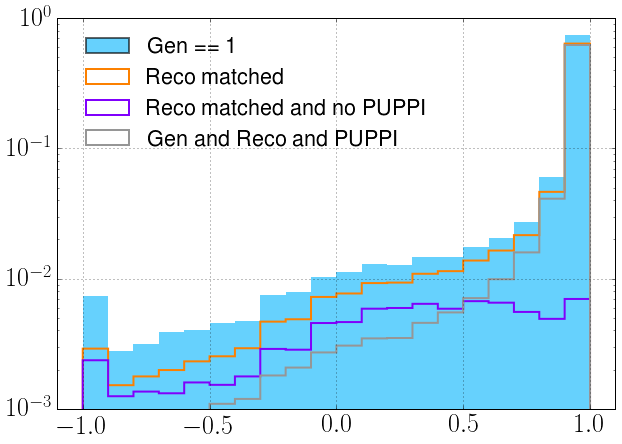

In [59]:
# Eta histograms Invert delta R
matplotlib.rcParams.update({'font.size': 26})

query1 = "numb_gen_jets == 1"
a = df_ww.query(query1).jet1_pu.hist(bins=22, range=(-1.1, 1.1), alpha=.6, color=[0, .7, .99],\
                                    label="Gen == 1", grid=False, edgecolor="none", linewidth=2,\
                                    weights=df_ww.query(query1).weight.values / df_ww.query(query1).weight.sum() )
query = "numb_jets == 1 & numb_gen_jets == 1 & dR_gj_rj < 0.4"
b= df_ww.query(query).jet1_pu.hist(bins=22, range=(-1.1, 1.1), color=[0.99, 0.5, 0],\
                                  label="Reco matched", histtype='step', figsize=(10.,7.), linewidth=2,\
                                  weights=df_ww.query(query).weight.values / df_ww.query(query1).weight.sum())

query = "numb_gen_jets == 1 & numb_jets == 1 & dR_gj_rj < 0.4 & numb_puppi_jets == 0"
e = df_ww.query(query).jet1_pu.hist(bins=22, range=(-1.1, 1.1), color=[0.5, 0, .99],\
                                   label="Reco matched and no PUPPI", grid=False, histtype='step', linewidth=2,\
                                   weights=df_ww.query(query).weight.values / df_ww.query(query1).weight.sum())

query = "numb_jets == 1 & numb_gen_jets == 1 & numb_puppi_jets == 1"
c= df_ww.query(query).jet1_pu.hist(bins=22, range=(-1.1, 1.1), color=[0.59, 0.59, 0.59],\
                                  label="Gen and Reco and PUPPI", histtype='step', figsize=(10.,7.), linewidth=2,\
                                  weights=df_ww.query(query).weight.values / df_ww.query(query1).weight.sum())



#props = dict(boxstyle='round', facecolor=[.94, .918, .83], alpha=0.5, edgecolor=[.94, .918, .83])
# Invert delta R stats
#post_dR = df_ww.query(query).shape[0]
#reco_1_gen_0 = df_ww.query("numb_puppi_jets == 1 & numb_gen_jets == 0").shape[0]
#s =  "Total : " + str(reco_1_gen_0) +\
#    "\nAfter dR 0.4: " + str(post_dR) +\
#    "\nFrac : " + str(float(post_dR)/reco_1_gen_0)
#plt.text(0.05, 0.95, s , fontsize=14, transform=c.transAxes,
#        verticalalignment='top', bbox=props, )
c.set_yscale("log")
plt.xlim((-1.1, 1.1))
plt.ylim((1e-3, 1))
plt.legend(c.get_legend_handles_labels()[0], c.get_legend_handles_labels()[1], framealpha=0.5, fontsize="small",\
           frameon=False, bbox_to_anchor=(0.7, 1.00))
plt.title("")

In [288]:
#Plot in ak4 in gen not in puppi
print df.query("numb_gen_jets ==1 & numb_jets > 0 & numb_puppi_jets == 0").shape
print df.query("numb_gen_jets ==1 & numb_puppi_jets == 0").shape
print df.query("numb_gen_jets ==1").shape

print df.query("numb_gen_jets ==1 & numb_jets > 0 & numb_puppi_jets == 0").shape
print df.query("numb_gen_jets ==1 & numb_puppi_jets == 0").shape
print df.query("numb_gen_jets ==1").shape

(4549, 152)
(7007, 152)
(48359, 152)


# Temp WWpt distribution

/home/gunter/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  after removing the cwd from sys.path.


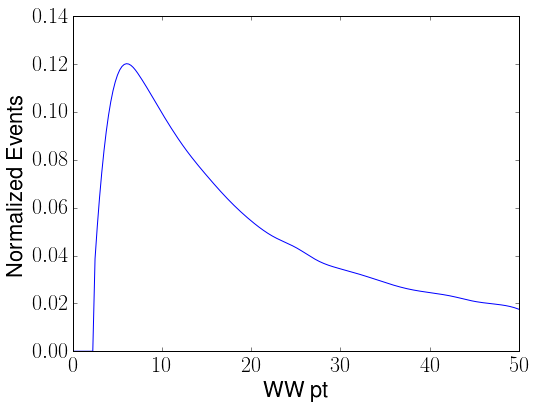

In [54]:
from scipy.interpolate import spline
a = np.histogram(df_ww.ww_pt, range=(0,50), bins=20, weights=np.ones(df_ww.shape[0]) /float(df_ww[df_ww.ww_pt < 50.].shape[0]) )
xnew = np.linspace(0,50,200)
wwpt = spline(a[1][1:], a[0], xnew)

matplotlib.rcParams.update({'font.size': 22})
plt.figure(figsize=(8,6))
plt.plot(xnew, wwpt)
plt.xlabel("WW pt")
plt.ylabel("Normalized Events")
plt.savefig("/home/gunter/WW_analysis/PAPER/myDir/notes/AN-17-169/trunk/FIGS/plots/wwpt_shape.pdf")
plt.show()

In [44]:
a[0]

array([ 234, 3942, 7625, 9413, 9895, 9565, 9281, 9019, 8077, 7689, 7231,
       6867, 6418, 6036, 5711, 5396, 5031, 4710, 4439, 4331, 4034, 3887,
       3674, 3587, 3364, 3148, 3006, 2976, 2794, 2752, 2575, 2664, 2442,
       2365, 2247, 2101, 2150, 2039, 2035, 1960, 1958, 1800, 1724, 1769,
       1657, 1616, 1592, 1517, 1450, 1374])

In [134]:
print 0.9576 * 22196. 
print 0.0377 * 22196., 0.9555 * 9536.
print 0.0047 * 22196., 0.0445 * 9536., 1. * 4641.

21254.8896
836.7892 9111.648
104.3212 424.352 4641.0


In [139]:
a["detector_matrix"][:,1] * a["doms_gen"][1]

array([  607.80421086,  8219.24952187,   709.00117683])

In [155]:
np.set_printoptions(suppress=True)
a = construct_matrix(df, "")
print "det\n", np.round(np.array(a["nums_det"]))
print "pu\n", np.round(np.array(a["nums_pu"]))
print "tot\n", np.round(a["nums"])

det
[[ 20989.    608.     16.]
 [  1162.   8219.    418.]
 [    45.    709.   4208.]]
pu
[[ 20697.      0.      0.]
 [   814.   9363.      0.]
 [   101.    436.   4962.]]
tot
[[ 20098.    584.     15.]
 [  1885.   7893.    399.]
 [   213.   1059.   4228.]]
